In [1]:
import sys
import os
import jax
import jax.numpy as jnp
from jax import vmap, pmap, jit, grad
import numpy as onp
from astropy.io import fits
from astropy import units as u
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import pysynphot as S
import time
from tqdm.notebook import tqdm
import morphine
import morphine_model
import scipy
from jax.config import config
config.update("jax_enable_x64", True)

from time import time as clock
from IPython.display import clear_output


In [2]:
###################
# Star Parameters #
###################

n_wavs = 20
central_wav = 550e-9 # m
width = 115e-9 # m
wavs = jnp.linspace(central_wav-width/1.6,central_wav+width/1.6,num=n_wavs) # Go a bit past the edges

filter_n,filter_sigma = 8,105e-9 
central_wav = onp.random.normal(scale=0e-11,loc=550e-9)
bandpass = morphine_model.supergaussian(wavs,central_wav,sigma=filter_sigma,n=filter_n)

primary_teff_A = 5790   #temp
primary_z_A = 0.2       #metallicity    - numbers from wikipedia
primary_logg_A = 4.3    #gravity
acenA = S.Icat('phoenix',primary_teff_A,primary_z_A,primary_logg_A)
specA = acenA.sample(wavs*1e10)
specA /= jnp.max(specA*bandpass)
weights_A = specA*bandpass

primary_teff_B = 5260   #temp
primary_z_B = 0.23      #metallicty
primary_logg_B = 4.37   #gravity
acenB = S.Icat('phoenix',primary_teff_B,primary_z_B,primary_logg_B)
specB = acenB.sample(wavs*1e10)
specB /= jnp.max(specB*bandpass)
weights_B = specB*bandpass

/suphys/cdea7424/.conda/envs/main/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
#############################
# Simulated Detector Params #
#############################
pscale = 0.156
num_pix = 512
pdiam2 = 0.13
osamp = 2

NZ = 20
zernikes = morphine.zernike.zernike_basis(NZ,npix=num_pix,outside=0.0) 

In [4]:
#####################
### Pupil Loading ###
#####################

def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = jnp.linspace(-c, c, size, endpoint=False)
    Xs, Ys = jnp.meshgrid(xs, xs)
    Rs = jnp.hypot(Xs, Ys)
    
    if radius is None:
        aperture = jnp.where(Rs > c, 0, jnp.ones([size, size]))
    else:
        aperture = jnp.where(Rs > radius, 0, jnp.ones([size, size]))
    return aperture

from scipy.ndimage import zoom
def get_toliman_pupil(size, path=None):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    if path is None:
        toliman_pupil = jnp.load("Toliman_pupil.npy")
    else:
        toliman_pupil = jnp.load("{}/Toliman_pupil.npy".format(path))
        
    phase = jnp.angle(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = get_aperture(size) * jnp.exp(1j * phase_scaled)
    return toliman_pupil_out

In [5]:
pupil = get_toliman_pupil(osamp*num_pix)
aperture_array = jnp.abs(pupil)
opd = central_wav*jnp.angle(pupil)/(2*jnp.pi)

In [6]:
toliman_Sidelobes = morphine_model.TolimanAperture(add_grating=True,grating_fact=0.0003,telescope_diam=0.13,
                                    central_wav=central_wav,achromatic_pupil = True,grating_amp=jnp.sqrt(0.1), pupil_file = 'Toliman_pupil.npy')


In [7]:
############################
# Image creating functions #
############################

zernikes = morphine.zernike.zernike_basis(NZ,npix=num_pix,outside=0.0) 
def generate_opsys(zern_coeffs = jnp.zeros(20)):
    zernikes = morphine.zernike.zernike_basis(NZ,npix=num_pix,outside=0.0) 

    # fix this
    opsys = morphine.OpticalSystem(npix = num_pix)
    opsys.add_pupil(toliman_Sidelobes)
    opsys.pupil_diameter = pdiam2 
    wf = opsys.input_wavefront()
    thinlens = morphine.ZernikeWFE(radius=pdiam2/2, coefficients=zern_coeffs, cached_zernikes=zernikes)
    opsys.add_pupil(thinlens)

    opsys.add_detector(pixelscale=pscale, fov_arcsec=pscale*num_pix/2) 
    return opsys

def get_psf(r, theta, osys, wl):
    osys.source_offset_r = r # arcseconds
    osys.source_offset_theta = theta # degrees
    psf = osys.propagate_mono(wl)[0].intensity
    return psf/onp.sum(psf)
get_psf_vmap = vmap(get_psf, in_axes=(None, None, None, 0))

def get_bb_psf(r, theta, osys, wavels, weights, sigma=0):
    psf_stack = get_psf_vmap(r, theta, osys, wavels)
    psf_stack *= weights.reshape([len(weights), 1, 1])
    psf = jnp.sum(psf_stack, axis=0)
    return psf/jnp.sum(psf)


def get_double_bb_psf(r, theta, osys, wavels, weights1, weights2, sigma = 0):
    starA = get_bb_psf(0, 0, osys, wavels, weights1, sigma)
    #starA = np.array(star1)
    starB = get_bb_psf(r, theta, osys, wavels, weights2, sigma)
   # starB = onp.array(star2)
    return starB*0.25+starA*0.75 ##approximate luminosity contribution

##################
# IMPORTANT NOTE #
##################

# I don't know why (something to do with jax), but the first time you use a function
# it is much slower than the second. Always run a function at least once before you
# put use it in a loop or something

In [8]:
##########################
# Noise adding functions #
##########################

def apply_photon_noise(image, seed = None):
    if seed is not None:
        onp.seed(seed)
    image_noisy = onp.random.poisson(image)
    return image_noisy

def generate_detector_noise(npixels, nimages, standard_deviation, seed=None):
    if seed is not None:
        onp.seed(seed)
    thermal_noise = jnp.abs(onp.random.normal(0, standard_deviation, [nimages, npixels, npixels]))
    if nimages == 1:
        return thermal_noise[0]
    return thermal_noise

def pixel_faults(rate = 0.001, mean = 0.97, std = 0.01):
    '''
    Adds inhomogenities to pixels by making some less sensitive.
    rate: what % of pixels are faulty
    mean: faulty pixel sensitivity
    std: std of gaussian spread around mean
    
    NOTE: Only takes 512x512 images
    '''
    faulty_map = onp.random.rand(512,512)  # careful with this
    faulty_map[faulty_map > rate] = 0
    faulty_map[faulty_map > 0] = 1
    
    num_nonZero = len(faulty_map[faulty_map == 1])
    
    sensitivities = std*onp.random.randn(num_nonZero)+mean
    sensitivities[sensitivities > 1] = 1

    faulty_map[faulty_map > 0] = sensitivities
    faulty_map[faulty_map == 0] = 1
    return faulty_map

def make_noisy(image, flux):
    # photon and detector and pixel
    dark_current = 2 # electrons 2 
    PSF_photons = apply_photon_noise(flux * image)
    detector_noise = generate_detector_noise(num_pix, 1, dark_current)
    noisy_PSF = PSF_photons + detector_noise
    # new addition below
    noisy_PSF = noisy_PSF*pixel_faults()
    noisy_PSF = noisy_PSF/jnp.sum(noisy_PSF)
    return noisy_PSF

def make_noisy1(image, flux):
    # photon and detector
    dark_current = 2 # electrons 2 
    PSF_photons = apply_photon_noise(flux * image)
    detector_noise = generate_detector_noise(num_pix, 1, dark_current)
    noisy_PSF = PSF_photons + detector_noise
    noisy_PSF = noisy_PSF/jnp.sum(noisy_PSF)
    return noisy_PSF

def make_noisy2(image, flux):
    # photon
    PSF_photons = apply_photon_noise(flux * image)
    noisy_PSF = PSF_photons
    noisy_PSF = noisy_PSF/jnp.sum(noisy_PSF)
    return noisy_PSF

CPU times: user 22.3 s, sys: 1.87 s, total: 24.2 s
Wall time: 11.7 s


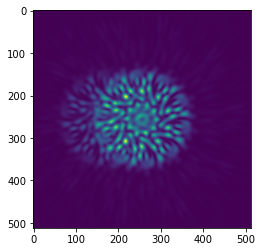

In [9]:
%%time
#n_wavs = 100
num_pix = 512
opsys = generate_opsys()

image = get_double_bb_psf(6,90,opsys,wavs, weights_A,weights_B)
plt.imshow(image)
print(get_cramer(image))

5.88559103869904e-06
5.717845253841899e-06


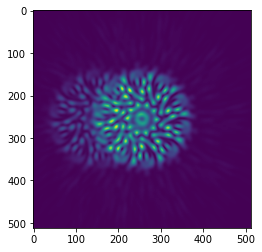

In [13]:
flux = 1.8e9 * 60 *60
image1 = get_double_bb_psf(6,90,opsys,wavs, weights_A,weights_B)
image2 = get_double_bb_psf(8,90,opsys,wavs, weights_A,weights_B)
rao1 = get_cramer(image1, flux)
rao2 = get_cramer(image2, flux)

print(rao1)
print(rao2)
plt.imshow(image2)

In [11]:


rao = onp.array([])
n_rao = onp.array([])
fluxes = onp.array([])
for i in tqdm(range(20)):
    flux = 10**i
    cramer = get_cramer(image, flux)
    rao = onp.append(rao, cramer)
    fluxes = onp.append(fluxes, flux)
    
    noisy = make_noisy(image, flux)
    n_cramer = get_cramer(noisy, flux)
    n_rao = onp.append(n_rao, n_cramer)
    
plt.figure(figsize = (12,8))
plt.title('Cramér-Rao Lower Bound as a function of noise and flux', fontsize = 20)
plt.plot(fluxes, rao, '--o', label = 'Noisless')
plt.plot(fluxes, n_rao, '--x', label = 'Noisy')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Flux', fontsize = 16)
plt.ylabel('Cramér-Rao Lower Bound', fontsize = 16)
plt.vlines(1.8e9, jnp.min(rao),jnp.max(rao), ls = '--', color = 'grey', label = '1 second exposure')
plt.vlines(1.8e9*60*60, jnp.min(rao),jnp.max(rao), ls = '-.', color = 'grey', label = '1 hour exposure')
plt.legend()

  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name 'get_cramer' is not defined

In [ ]:
num_pix = 512
opsys = generate_opsys()

image512 = get_bb_psf(0,0,opsys,wavs, weights_A)
plt.imshow(image512)

(510, 510)
(510, 510)


Text(0.5, 1.0, 'Relative intensity of the squared Gradient \n of the TOLIMAN PSF')

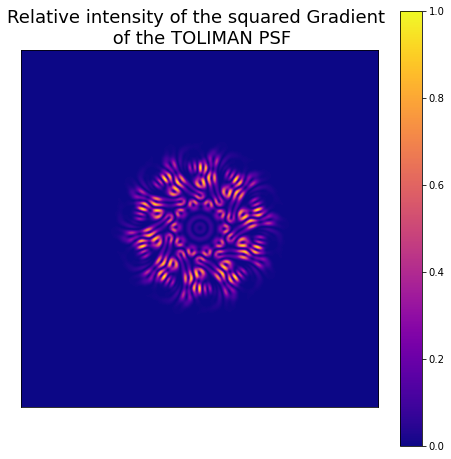

In [112]:
dg_dx = (image512[:,2:]-image512[:,:-2])/2
dg_dy = (image512[2:]-image512[:-2])/2

print(onp.shape(dg_dx[1:-1]))
print(onp.shape(dg_dy[:,1:-1]))

gradient = jnp.abs(dg_dy[:,1:-1]**2 + dg_dx[1:-1,:]**2)
gradient /= jnp.max(gradient)
plt.figure(figsize = (8,8))
plt.imshow(gradient, cmap = 'plasma')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Relative intensity of the squared Gradient \n of the TOLIMAN PSF', fontsize = 18)

In [66]:
c_rao = onp.array([])
c_n_rao = onp.array([])

for i in tqdm(range(20)):
    flux = 10**i
    cramer = get_cramer(image512, flux)
    c_rao = onp.append(c_rao, cramer)
    
    noisy = make_noisy(image512, flux)
    c_n_cramer = get_cramer(noisy, flux)
    c_n_rao = onp.append(c_n_rao, c_n_cramer)

  0%|          | 0/20 [00:00<?, ?it/s]

TypeError: add got incompatible shapes for broadcasting: (2000, 2000), (512, 512).

ValueError: x and y must have same first dimension, but have shapes (20,) and (24,)

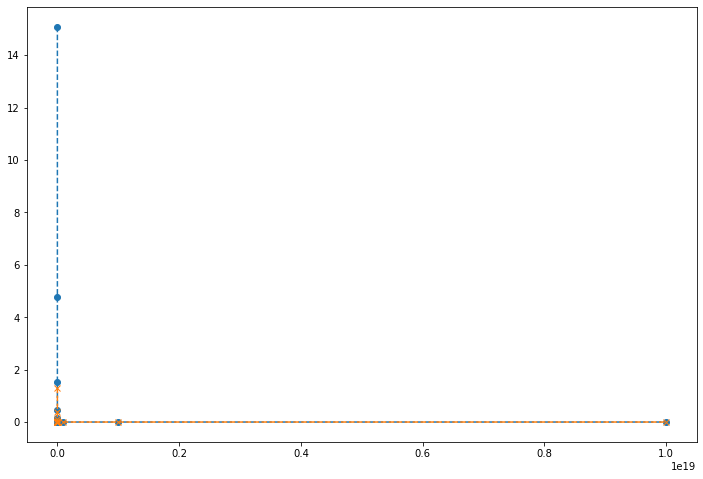

In [65]:
plt.figure(figsize = (12,8))
plt.plot(fluxes, rao, '--o', label = 'Noisless')
plt.plot(fluxes, n_rao, '--x', label = 'Noisy')
plt.plot(fluxes, c_rao, '--v', label = 'Cropped Noisless')
plt.plot(fluxes, c_n_rao, '--*', label = 'Cropped Noisy')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Flux')
plt.ylabel('Cramér-Rao Lower Bound')
plt.legend()

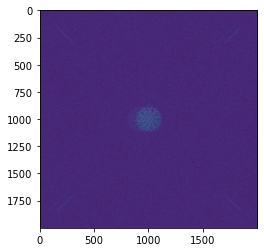

In [40]:
flux = 10**5
noisy = make_noisy(image, flux)
plt.imshow(noisy)

CPU times: user 20.9 s, sys: 1.66 s, total: 22.5 s
Wall time: 10.5 s


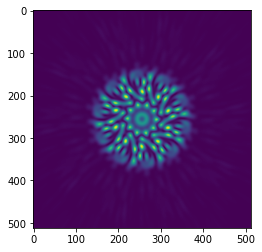

In [9]:
%%time
#n_wavs = 100
num_pix = 512
opsys = generate_opsys()

image = get_double_bb_psf(0,0,opsys,wavs, weights_A,weights_B)
plt.imshow(image)

1.75 s ± 5.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


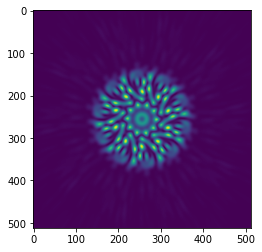

In [10]:
%%timeit
image = get_double_bb_psf(0,0,opsys,wavs, weights_A,weights_B)
plt.imshow(image)

Text(0.5, 1.0, 'Recovered Spectrum')

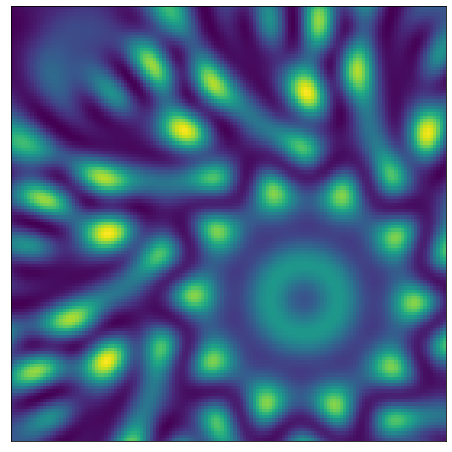

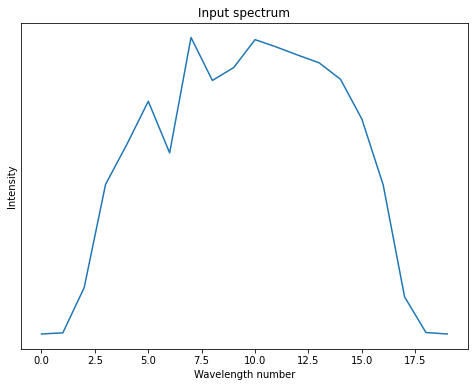

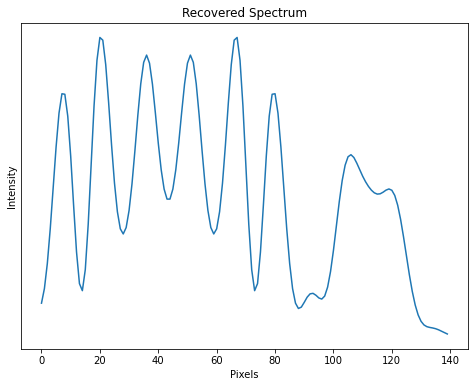

In [11]:
plt.figure(figsize = (8,8))
plt.imshow(image[165:300,165:300])
plt.xticks([])
plt.yticks([])

plt.figure(figsize = (8,6))
plt.plot(weights_A)
plt.ylabel('Intensity')
plt.xlabel('Wavelength number')
plt.title('Input spectrum')
plt.yticks([])


plt.figure(figsize = (8,6))
plt.plot(onp.flip(onp.diag(image[160:300,160:300])))
plt.yticks([])
plt.xlabel('Pixels')
plt.ylabel('Intensity')
plt.title('Recovered Spectrum')

In [12]:
ls = onp.linspace(0,2,11)
print(ls)
for j in range(9):
    print('{:.1f}'.format(ls[j+1]))
    
    

[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]
0.2
0.4
0.6
0.8
1.0
1.2
1.4
1.6
1.8


In [13]:
# for i in tqdm(range(20)):
#     dirs = '20wavsPSFs/Zernikes 1psf/'
#     zern = morphine.zernike.zern_name(i+1)
#     path = dirs+zern
#     for j in range(9):
#         coeffs = onp.zeros((20))
#         coeffs[i] = 1e-9*ls[j+1]
        
#         opsys = generate_opsys(coeffs)
#         image = get_bb_psf(0,0,opsys,wavs, weights_A)
        
#         name = path+'/{:.1f}nm'.format(ls[j+1])
#         onp.save(name, image)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
#####################
# Fitting functions #
#####################

def objective(params, input_image):
    # Input image must be 512x512
    #print(params)
    if len(params) > 4:
        zernikes = []
        for i in range(len(params)-4):
            zern = params[3+i]
            zernikes = jnp.append(zernikes, zern)
        if len(zernikes) < 20:
            num_zeros = 20 - len(zernikes)
            zeros = jnp.zeros(num_zeros)
            zernikes = jnp.append(zernikes, zeros)
            
        opsys = generate_opsys(zernikes)
        params = params[:4]
    else:
        opsys = generate_opsys()
 

    if len(params) == 1:
        offset = params[0]
        
        fmodel_image = get_double_bb_psf(6+offset,90,opsys, wavs, weights_A, weights_B)
    elif len(params) == 2:
        offset = params[0]
        roll   = params[1]
        
        fmodel_image = get_double_bb_psf(6+offset,90+roll,opsys, wavs, weights_A, weights_B)
    elif len(params) == 4:
        offset       = params[0]
        roll         = params[1]
        jitter_r     = params[2]
        jitter_theta = params[3]
        
        fmodel_image = get_double_bb_psf(6+offset+jitter_r ,90+roll+jitter_theta ,opsys, wavs, weights_A, weights_B)
        
    
    noise = jnp.sqrt(input_image)
    
    residual = (input_image - fmodel_image)/noise
    
    chi2 = jnp.sum(residual**2)
    
    return chi2

def objective2(params, input_image, zernikes):
    opsys = generate_opsys(zernikes)
 

    if len(params) == 1:
        offset = params[0]
        
        fmodel_image = get_double_bb_psf(6+offset,90,opsys, wavs, weights_A, weights_B)
    elif len(params) == 2:
        offset = params[0]
        roll   = params[1]
        
        fmodel_image = get_double_bb_psf(6+offset,90+roll,opsys, wavs, weights_A, weights_B)
    elif len(params) == 4:
        offset       = params[0]
        roll         = params[1]
        jitter_r     = params[2]
        jitter_theta = params[3]
        
        fmodel_image = get_double_bb_psf(6+offset+jitter_r ,90+roll+jitter_theta ,opsys, wavs, weights_A, weights_B)
        ## fix this
    noise = jnp.sqrt(input_image)
    
    residual = (input_image - fmodel_image)/noise
    
    chi2 = jnp.sum(residual**2)
    
    return chi2

def objective3(params, input_image, zernikes):
    
    zern_6 = params[1]
    #zernikes[6] = zern_6
    zernikes.at[6].set(zern_6)
    
    opsys = generate_opsys(zernikes)
 

    offset = params[0]

    fmodel_image = get_double_bb_psf(6+offset,90,opsys, wavs, weights_A, weights_B)

    noise = jnp.sqrt(input_image)
    
    residual = (input_image - fmodel_image)/noise
    
    chi2 = jnp.sum(residual**2)
    
    return chi2

def objective4(params, input_image, zernikes):
    
    zern_2 = params[1]
    zern_3 = params[2]
    #zernikes[6] = zern_6
    zernikes.at[2].set(zern_2)
    zernikes.at[3].set(zern_3)
    
    opsys = generate_opsys(zernikes)
 

    offset = params[0]

    fmodel_image = get_double_bb_psf(6+offset,90,opsys, wavs, weights_A, weights_B)

    noise = jnp.sqrt(input_image)
    
    residual = (input_image - fmodel_image)/noise
    
    chi2 = jnp.sum(residual**2)
    
    return chi2

In [14]:
gradient = grad(objective)
gradient2 = grad(objective2)
gradient3 = grad(objective3)
gradient4 = grad(objective4)



In [10]:
def cramer_rao_bound(image):
    """ Calculate the Cramer-Rao bound on the accuracy of a position measurement for a single image.
    Returns the expected standard deviation of the position measurement in the x and y directions.
    """
    # calculate derivative at each pixel. Use symmetric two-point derivative
    dg_dx = (image[:,2:]-image[:,:-2])/2
    dg_dy = (image[2:]-image[:-2])/2

    var_x = 1/(jnp.sum(dg_dx**2 / image[:,1:-1]))
    var_y = 1/(jnp.sum(dg_dy**2 / image[1:-1]))

    std_x = jnp.sqrt(var_x)
    std_y = jnp.sqrt(var_y)
    
    return std_x,std_y

def get_cramer(image, flux):
    std_x, std_y = cramer_rao_bound(image*flux)
    std_sec_x = std_x*jnp.sqrt(3) # magic number is the binary contrast ratio
    std_sec_y = std_y*jnp.sqrt(3)

    std_sep_x = jnp.sqrt(std_x**2+std_sec_x**2)
    std_sep_y = jnp.sqrt(std_y**2+std_sec_y**2)
    std_sep = onp.mean([std_sep_x,std_sep_y])
    return std_sep

inf
inf


<ipython-input-21-018fd49e6a08>:3: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(new_image)
<ipython-input-21-018fd49e6a08>:3: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(new_image)
<ipython-input-21-018fd49e6a08>:9: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(anch)
<ipython-input-21-018fd49e6a08>:9: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(anch)


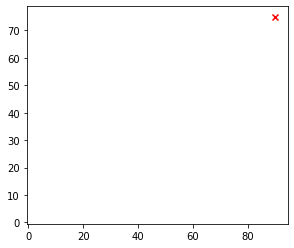

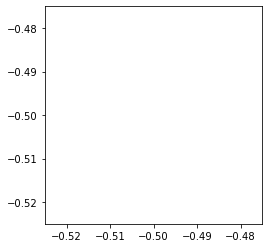

In [21]:
new_image = image[1000-128:1000+128,1000-128:1000+128]
w = 6
plt.imshow(new_image)
plt.scatter(90,75, marker = 'x', color = 'red')
print(get_cramer(new_image, 1.8e9 *60 *60))

plt.figure()
anch = new_image[90-w:90+w,67-w:67+w]
plt.imshow(anch)
print(get_cramer(anch, 1.8e9))

In [ ]:
t = onp.linspace(0,100,101)
planet_signal = 0.5e-6*onp.sin(2*jnp.pi*(1/100)*t)

plt.plot(planet_signal)

In [15]:
%%time
osys = generate_opsys(jnp.zeros((20)))

CPU times: user 1.27 s, sys: 275 ms, total: 1.55 s
Wall time: 927 ms


Sum of image: 1.0000000000000002
Max of image: 7.351206531194388e-05
CPU times: user 12 s, sys: 1.26 s, total: 13.3 s
Wall time: 1.91 s


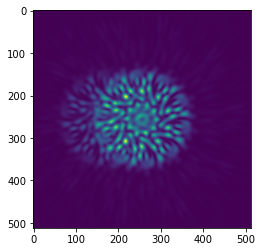

In [16]:
%%time
image = get_double_bb_psf(6,90,osys, wavels = wavs,weights1 =  weights_A, weights2 = weights_B)
print('Sum of image: ' + str(jnp.sum(image)))
print('Max of image: ' + str(jnp.max(image)))
plt.imshow(image)

In [23]:
print(get_cramer(image, 1.8e9*60*60))

5.88559103869904e-06


In [17]:
def random_walk(num_steps, std, init_pos = 0):
    pos = onp.array([init_pos])
    for i in range(num_steps-1):
        step = onp.random.normal(0, std)
        new_pos = pos[-1] + step
        if new_pos < 0:
            new_pos = 0
        pos = onp.append(pos, new_pos)
    return pos

def random_walk2(num_steps, std, init_pos = 0):
    pos = onp.array([init_pos])
    for i in range(num_steps-1):
        step = onp.random.normal(0, std)
        new_pos = pos[-1] + step
        #if new_pos < 0:
        #    new_pos = 0
        pos = onp.append(pos, new_pos)
    return onp.abs(pos)

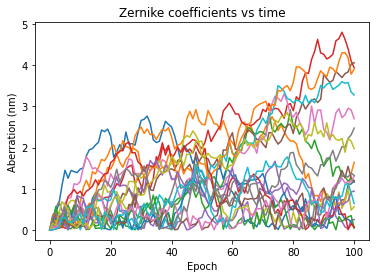

In [69]:
#onp.random.seed(0)
plt.figure()

walk_array = onp.zeros((20,101))
for i in range(20):
    walk = random_walk2(101, 0.2)
    walk_array[i,:] = walk
    plt.plot(walk)
plt.xlabel('Epoch')
plt.ylabel('Aberration (nm)')
plt.title('Zernike coefficients vs time')
    
rms = jnp.sqrt((1/(20*101)) * jnp.sum(walk_array**2))


1.2726016358940075
1.2830673609791956 Piston
1.9649552845989304 Tilt X
0.353696560874782 Tilt Y
0.1782173957690684 Focus
0.6529885996297861 Astigmatism 45
0.15470645385278267 Astigmatism 0
0.3722524842843326 Coma Y
0.4081608738721263 Coma X
0.7344453342045613 Trefoil Y
2.2572110414896107 Trefoil X
0.7386535680716226 Spherical
2.304371923630914 2nd Astig 0
0.848425474411955 2nd Astig 45
0.8893538000511705 Tetrafoil 0
0.5700952052642212 Tetrafoil 22.5
0.8214500271112679 2nd coma X
0.6530645680642032 2nd coma Y
0.6681261142249235 3rd Astig X
0.24732382368434494 3rd Astig Y
1.153378253067135 Pentafoil X


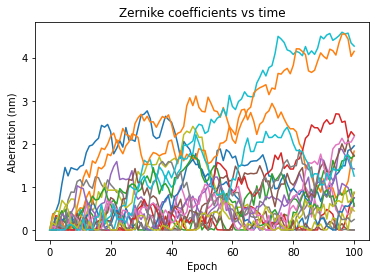

In [76]:
onp.random.seed(0)
plt.figure()

walk_array = onp.zeros((20,101))
for i in range(20):
    walk = random_walk(101, 0.2)
    walk_array[i,:] = walk
    plt.plot(walk)
plt.xlabel('Epoch')
plt.ylabel('Aberration (nm)')
plt.title('Zernike coefficients vs time')
    
rms = jnp.sqrt((1/(20*101)) * jnp.sum(walk_array**2))
print(rms)

for i in range(20):
    print(jnp.mean(walk_array[i,:]), morphine.zernike.zern_name(i+1))

In [18]:
# get normalisation factors
zern_coeffs = onp.ones(20)*0
opsys = morphine.OpticalSystem(npix = num_pix)
opsys.add_pupil(toliman_Sidelobes)
opsys.pupil_diameter = pdiam2 
wf = opsys.input_wavefront()
thinlens = morphine.ZernikeWFE(radius=pdiam2/2, coefficients=zern_coeffs, cached_zernikes=zernikes)

norm_factors = onp.ones(20)
for i in range(20):
    zern_coeffs = onp.zeros(20)
    zern_coeffs[i] = 1
    thinlens = morphine.ZernikeWFE(radius=pdiam2/2, coefficients=zern_coeffs, cached_zernikes=zernikes)
    wf = opsys.input_wavefront(550e-9)
    #plt.figure()
    #plt.imshow(thinlens.get_opd(wf))
    name = morphine.zernike.zern_name(i+1)
   # plt.title(name)
    theMax = jnp.max(thinlens.get_opd(wf))
    theMin = jnp.min(thinlens.get_opd(wf))
    #plt.xlabel('Max: ' + str('{:.3f}'.format(theMax)) + '    Min: ' + str('{:.3f}'.format(theMin)))
   # plt.colorbar()
   # print(jnp.mean(thinlens.get_opd(wf)))
    diff = theMax - theMin
    norm_factors[i] = diff
    print(name + str(':  {:.3f}'.format(diff)))

print(norm_factors)

Piston:  1.000
Tilt X:  3.984
Tilt Y:  3.984
Focus:  3.464
Astigmatism 45:  4.890
Astigmatism 0:  4.861
Coma Y:  5.634
Coma X:  5.634
Trefoil Y:  5.651
Trefoil X:  5.651
Spherical:  3.354
2nd Astig 0:  6.225
2nd Astig 45:  6.295
Tetrafoil 0:  6.264
Tetrafoil 22.5:  6.316
2nd coma X:  6.898
2nd coma Y:  6.898
3rd Astig X:  6.909
3rd Astig Y:  6.909
Pentafoil X:  6.901
[1.         3.98434442 3.98434442 3.46387609 4.8899928  4.86068759
 5.63374287 5.63374287 5.65120485 5.65120485 3.35399921 6.22466721
 6.2950583  6.26367472 6.31621779 6.89791576 6.89791576 6.90869379
 6.90869379 6.90071852]


In [ ]:
zerns = [1,2,6,7,8,9]
zernikes = onp.zeros(20)
for i in range(len(zerns)):
    zernikes[zerns[i]] = 1e-9 / norm_factors[zerns[i]]
    
print(zernikes)

In [39]:
############################
# generate 1nm norm images #
############################

# generate with the first 5 odd modes and see how it reacts


# aberration_magnitude = 1/norm_factors[i]
# zernike_coefficients = onp.zeros(20)
# zernike_coefficients[i] = aberration_magnitude *1e-9

zerns = [1,2,6,7,8,9,15,16,17,18,19]
zernikes = onp.zeros(20)
for i in range(len(zerns)):
    zernikes[zerns[i]] = 1e-9 / norm_factors[zerns[i]]
    
zernike_coefficients = zernikes
optical_system = generate_opsys(zernikes)
#zern = morphine.zernike.zern_name(i+1)
    
for j in tqdm(range(101)):
    image = get_double_bb_psf(6+planet_signal[j] ,90, optical_system, wavels = wavs,weights1 =  weights_A, weights2 = weights_B)

    image_HDU = fits.ImageHDU(image)
    hdr = fits.Header()

    hdr['Signal']  = onp.float64(planet_signal[j])
    hdr['JitterX'] = 0
    hdr['JitterY'] = 0
    hdr['Roll']    = 0
    for k in range(20):
        hdr['zern_{}'.format(k)] = zernike_coefficients[k]

    head = fits.PrimaryHDU(header = hdr)
    hdu = fits.HDUList([head, image_HDU])

    name = 'Epoch{}.fits'.format(j)

    hdu.writeto('20wavsPSFs/Zernikes/first11/1nm_norm/'+name)

  0%|          | 0/101 [00:00<?, ?it/s]

In [22]:
############################
# generate 1nm norm images #
############################



# aberration_magnitude = 1/norm_factors[i]
# zernike_coefficients = onp.zeros(20)
# zernike_coefficients[i] = aberration_magnitude *1e-9

zernikes = onp.zeros(20)
for i in range(20):
    zernikes[i] = 2e-9 / norm_factors[i]
    
zernike_coefficients = zernikes
optical_system = generate_opsys(zernikes)
#zern = morphine.zernike.zern_name(i+1)
    
for j in tqdm(range(101)):
    image = get_double_bb_psf(6+planet_signal[j] ,90, optical_system, wavels = wavs,weights1 =  weights_A, weights2 = weights_B)

    image_HDU = fits.ImageHDU(image)
    hdr = fits.Header()

    hdr['Signal']  = onp.float64(planet_signal[j])
    hdr['JitterX'] = 0
    hdr['JitterY'] = 0
    hdr['Roll']    = 0
    for k in range(20):
        hdr['zern_{}'.format(k)] = zernike_coefficients[k]

    head = fits.PrimaryHDU(header = hdr)
    hdu = fits.HDUList([head, image_HDU])

    name = 'Epoch{}.fits'.format(j)

    hdu.writeto('20wavsPSFs/Zernikes/all/2nm_norm/'+name)

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
print(stop here scum)

In [ ]:
for i in range(12):
    i = i
    print(morphine.zernike.zern_name(i+1))

FileNotFoundError: [Errno 2] No such file or directory: '20wavsPSFs/Zernikes/3rd Astig Y/Estimate_Results/1nm-overshot0-5.npy'

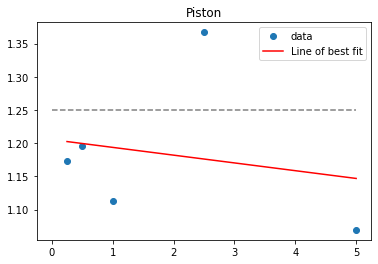

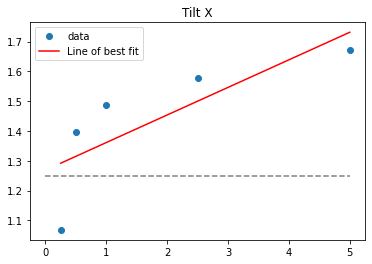

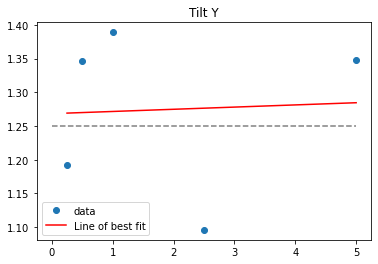

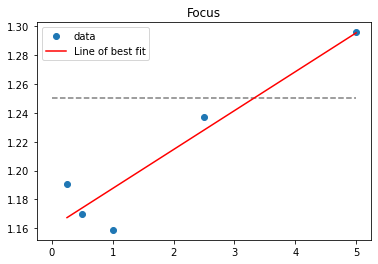

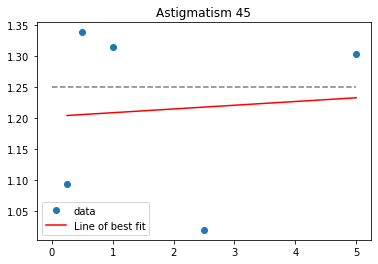

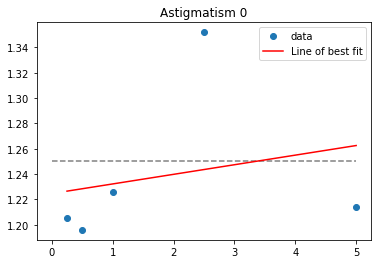

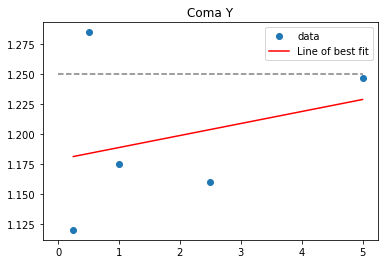

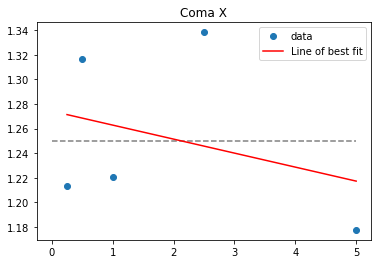

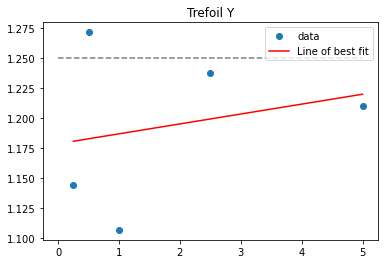

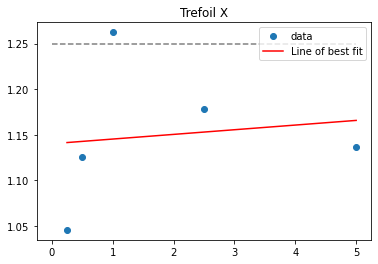

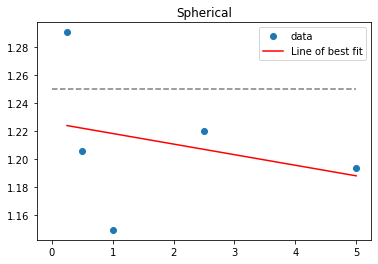

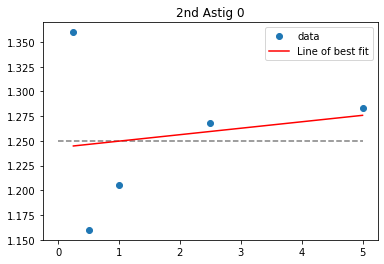

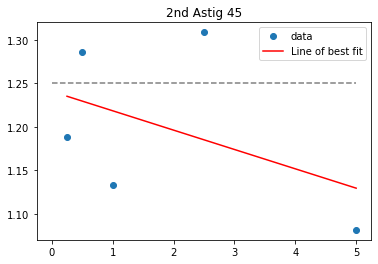

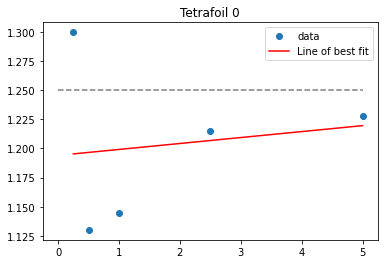

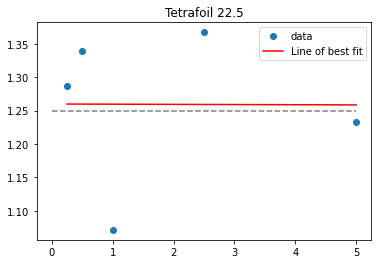

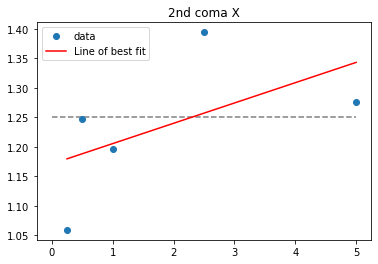

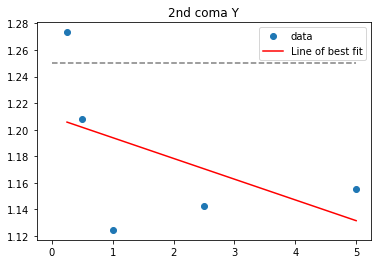

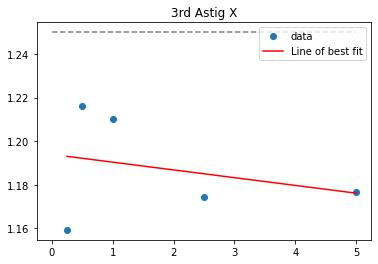

In [25]:
sum_stds = [0,0,0,0,0]

for i in range(20):
    zern  = morphine.zernike.zern_name(i+1)
    
    data1b = onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/second50_1nm-overshot0-25.npy'.format(zern))
    data2b = onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/second50_1nm-overshot0-5.npy'.format(zern))
    data3b = onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/second50_1nm-overshot1.npy'.format(zern))
    data4b = onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/second50_1nm-overshot2-5.npy'.format(zern))
    data5b = onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/second50_1nm-overshot5.npy'.format(zern))

    data1a = onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/1nm-overshot0-25.npy'.format(zern))
    data2a = onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/1nm-overshot0-5.npy'.format(zern))
    data3a = onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/1nm-overshot1.npy'.format(zern))
    data4a = onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/1nm-overshot2-5.npy'.format(zern))
    data5a = onp.load('20wavsPSFs/Zernikes/{}/Estimate_Results/1nm-overshot5.npy'.format(zern))
    
    data1 = onp.hstack((data1a, data1b))
    data2 = onp.hstack((data2a, data2b))
    data3 = onp.hstack((data3a, data3b))
    data4 = onp.hstack((data4a, data4b))
    data5 = onp.hstack((data5a, data5b))

    std1 = jnp.std(data1 - planet_signal[:-1])
    std2 = jnp.std(data2 - planet_signal[:-1])
    std3 = jnp.std(data3 - planet_signal[:-1])
    std4 = jnp.std(data4 - planet_signal[:-1])
    std5 = jnp.std(data5 - planet_signal[:-1])

    stds = onp.array([std1, std2, std3, std4, std5])*2/pscale
    sum_stds += stds
    x_array = onp.array([0.25, 0.5, 1, 2.5, 5])
    
    z = onp.polyfit(x_array, stds/5.88e-6, 1)

    plt.figure()
    plt.plot(x_array, stds/5.88e-6, 'o', label = 'data')
    plt.plot(x_array, z[0]*x_array+z[1], color = 'red', label = 'Line of best fit')
    plt.hlines(1.25,0,5, ls= '--', color = 'grey')
    plt.title(zern)
    plt.legend()



[21.34427958 22.41063724 21.66609218 22.63172021 22.27549882]


In [ ]:
# need to finish off tilt X
# and coma X

#################
# Calculate fit #
#################

flux = 1.8e9 * 60 * 60
overshot = [1.0025, 1.005, 1.01, 1.025, 1.05]
overshot_names = ['0-25', '0-5', '1', '2-5', '5']

for m in tqdm(range(20)):
    zern = morphine.zernike.zern_name(m+1)
    path = '20wavsPSFs/Zernikes/{}/1nm_norm/'.format(zern)
    
    for k in tqdm(range(len(overshot))):
        print(zern+ ' '+ str(overshot[k]))
        recovered_signal = []
        for i in tqdm(range(50)):
            full_path = path + 'Epoch{}.fits'.format(i+50)
            data = fits.open(full_path)
            image = data[1].data
            hdr = data[0].header

            ls = []
            for j in range(20):
                ls = onp.append(ls, hdr['zern_{}'.format(j)]*(overshot[k]))
            x0 = hdr['signal']
            input_image = make_noisy2(image, flux)
            fit =  scipy.optimize.minimize(objective2, x0,method='bfgs', args=(input_image, ls), jac = gradient2, options={'gtol': 1e-08})
            seperation_estimate = fit.x[0]

            recovered_signal = onp.append(recovered_signal, seperation_estimate)

        name = 'second50_1nm-overshot{}'.format(overshot_names[k])
        onp.save('20wavsPSFs/Zernikes/{}/Estimate_Results/'.format(zern)+name, recovered_signal)

In [20]:
for j in range(20):    
    if j in [1,2,6,7,8,9,15,16,17,18,19]:
        print(j)

1
2
6
7
8
9
15
16
17
18
19


In [25]:
print(1-onp.array(overshot)+1)

[1.     0.999  0.9975 0.995  0.975 ]


In [19]:
# need to finish off tilt X
# and coma X

#################
# Calculate fit #
#################

flux = 1.8e9 * 60 * 60
overshot = [ 1.001, 1.0025, 1.005, 1.025]
#overshot = 1-onp.array(overshot)+1
overshot_names = [ '0.1', '0.25', '0.5', '2.5']
path = '20wavsPSFs/Zernikes/all/1nm_norm/'

for k in tqdm(range(len(overshot))):
    print( str(overshot[k]))
    recovered_signal = []
    for i in tqdm(range(50)):
        full_path = path + 'Epoch{}.fits'.format(i)
        data = fits.open(full_path)
        image = data[1].data
        hdr = data[0].header

        ls = []
        for j in range(20):
            ls = onp.append(ls, hdr['zern_{}'.format(j)]*(overshot[k]))
        x0 = hdr['signal']
        input_image = make_noisy2(image, flux)
        fit =  scipy.optimize.minimize(objective2, x0,method='bfgs', args=(input_image, ls), jac = gradient2, options={'gtol': 1e-08})
        seperation_estimate = fit.x[0]

        recovered_signal = onp.append(recovered_signal, seperation_estimate)

    name = '1nm-overshot{}_correctly_normalised'.format(overshot_names[k])
    onp.save('20wavsPSFs/Zernikes/all/Results/'+name, recovered_signal)

  0%|          | 0/4 [00:00<?, ?it/s]

1.001


  0%|          | 0/50 [00:00<?, ?it/s]

1.0025


  0%|          | 0/50 [00:00<?, ?it/s]

1.005


  0%|          | 0/50 [00:00<?, ?it/s]

1.025


  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
#################
# Calculate fit #
#################

flux = 1.8e9 * 60 * 60
overshot = [ 1.001, 1.0025, 1.005, 1.025]
#overshot = 1-onp.array(overshot)+1
overshot_names = [ '0.1', '0.25', '0.5', '2.5']
path = '20wavsPSFs/Zernikes/all/1nm/'

for k in tqdm(range(len(overshot))):
    print( str(overshot[k]))
    recovered_signal = []
    for i in tqdm(range(50)):
        full_path = path + 'Epoch{}.fits'.format(i)
        data = fits.open(full_path)
        image = data[1].data
        hdr = data[0].header

        ls = []
        for j in range(20):
            ls = onp.append(ls, hdr['zern_{}'.format(j)]*(overshot[k]))
        x0 = hdr['signal']
        input_image = make_noisy2(image, flux)
        fit =  scipy.optimize.minimize(objective2, x0,method='bfgs', args=(input_image, ls), jac = gradient2, options={'gtol': 1e-08})
        seperation_estimate = fit.x[0]

        recovered_signal = onp.append(recovered_signal, seperation_estimate)

    name = '1nm-overshot{}_incorrectly_normalised'.format(overshot_names[k])
    onp.save('20wavsPSFs/Zernikes/all/Results/'+name, recovered_signal)

  0%|          | 0/4 [00:00<?, ?it/s]

1.001


  0%|          | 0/50 [00:00<?, ?it/s]

1.0025


  0%|          | 0/50 [00:00<?, ?it/s]

1.005


  0%|          | 0/50 [00:00<?, ?it/s]

1.025


  0%|          | 0/50 [00:00<?, ?it/s]

In [47]:
odd = [1,2,6,7,8,9,15,16,17,18,19]
for m in range(len(odd)): 
    ls = onp.zeros(20)
    for j in range(m+1):
        ls[odd[j]] = hdr['zern_{}'.format(odd[j])]
    print(ls)

# for i in range(len(odd)):
#     print(odd[i], morphine.zernike.zern_name(odd[i]))
    
neg_odd = [1,4,5,6,9]
#for i in range(len(odd)):
   # print(odd[neg_odd[i]])
    
neg_odd_zern = [2,8,9,15,18]
for i in range(len(neg_odd_zern)):
    print(morphine.zernike.zern_name(neg_odd_zern[i]+1))
    

for m in range(len(neg_odd_zern)): 
    ls = onp.zeros(20)
    for j in range(m+1):
        ls[neg_odd_zern[j]] = hdr['zern_{}'.format(neg_odd_zern[j])]
    print(ls)


[0.         0.25098232 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.         0.25098232 0.25098232 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.         0.25098232 0.25098232 0.         0.         0.
 0.17750189 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.         0.25098232 0.25098232 0.         0.         0.
 0.17750189 0.17750189 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.         0.25098232 0.25098232 0.         0.         0.
 0.17750189 0.17750189 0.17695342 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.     

In [55]:
#################
# Calculate fit #
#################

flux = 1.8e9 * 60 * 60
overshot = [ 1.01]
overshot_names = ['1']
path = '20wavsPSFs/Zernikes/all/1nm_norm/'
odd = [1,2,6,7,8,9,15,16,17,18,19]
#neg_odd_zern = [2,8,9,15,18]

for m in tqdm(range(len(odd))):
    for k in tqdm(range(len(overshot))):
        print( str(overshot[k]))
        recovered_signal = []
        for i in tqdm(range(50)):
            full_path = path + 'Epoch{}.fits'.format(i)
            data = fits.open(full_path)
            image = data[1].data
            hdr = data[0].header

            ls = onp.zeros(20)
            for j in range(m+1):
                ls[odd[j]] = hdr['zern_{}'.format(odd[j])]*(overshot[k])

            x0 = hdr['signal']
            input_image = make_noisy2(image, flux)
            fit =  scipy.optimize.minimize(objective2, x0,method='bfgs', args=(input_image, ls), jac = gradient2, options={'gtol': 1e-08})
            seperation_estimate = fit.x[0]

            recovered_signal = onp.append(recovered_signal, seperation_estimate)

        name = 'corrected_1nm-overshot{}_fitfirst_{}odd'.format(overshot_names[k],m+1)

        onp.save('20wavsPSFs/Zernikes/all/Results/'+name, recovered_signal)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

In [54]:
#################
# Calculate fit #
#################

flux = 1.8e9 * 60 * 60
overshot = [1.0025, 1.005, 1.01]
overshot_names = ['0.25', '0.5','1']
path = '20wavsPSFs/Zernikes/all/1nm_norm/'
#odd = [1,2,6,7,8,9,15,16,17,18,19]
neg_odd_zern = [2,8,9,15,18]

for m in tqdm(range(1)):
    m = len(neg_odd_zern)-1
    for k in tqdm(range(len(overshot))):
        print( str(overshot[k]))
        recovered_signal = []
        for i in tqdm(range(50)):
            full_path = path + 'Epoch{}.fits'.format(i)
            data = fits.open(full_path)
            image = data[1].data
            hdr = data[0].header

            ls = onp.zeros(20)
            for j in range(m+1):
                ls[neg_odd_zern[j]] = hdr['zern_{}'.format(neg_odd_zern[j])]*(overshot[k])

            x0 = hdr['signal']
            input_image = make_noisy2(image, flux)
            fit =  scipy.optimize.minimize(objective2, x0,method='bfgs', args=(input_image, ls), jac = gradient2, options={'gtol': 1e-08})
            seperation_estimate = fit.x[0]

            recovered_signal = onp.append(recovered_signal, seperation_estimate)

        name = '1nm-overshot{}_negslope_odd'.format(overshot_names[k])

        onp.save('20wavsPSFs/Zernikes/all/Results/'+name, recovered_signal)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

1.0025


  0%|          | 0/50 [00:00<?, ?it/s]

1.005


  0%|          | 0/50 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

[1.05321869e+07 3.64497710e+01 5.42400643e+01 6.20583771e+01
 5.87002587e+01 4.00682386e+01 3.60325483e+01 4.30455338e+01
 9.05052148e+01 2.40973262e+01 7.15171253e+01]


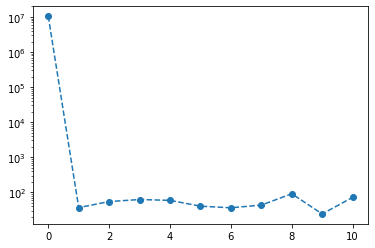

In [26]:
stds = onp.array([])

for i in range(11):
    data = onp.load('20wavsPSFs/Zernikes/all/Results/1nm-overshot1_fitfirst_{}odd.npy'.format(i+1))
    std = onp.std(data)
    stds = onp.append(stds, std)
    
stds *= 2/0.156
plt.plot(stds/5.88e-6, '--o')
plt.yscale('log')

print(stds/5.88e-6)

[102.29383597  55.52117732 143.24260156  76.60357281  49.37476166
  40.88159774  54.21313266  32.51439968  42.65590863  43.89754131
  33.96612036]


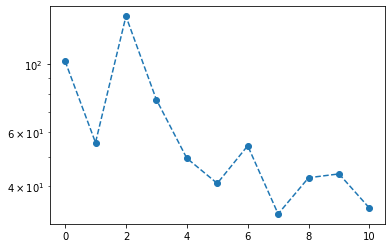

In [27]:
stds = onp.array([])

for i in range(11):
    data = onp.load('20wavsPSFs/Zernikes/all/Results/corrected_1nm-overshot1_fitfirst_{}odd.npy'.format(i+1))
    std = onp.std(data)
    stds = onp.append(stds, std)
    
stds *= 2/0.156
plt.plot(stds/5.88e-6, '--o')
plt.yscale('log')

print(stds/5.88e-6)

[43.99372108 53.98818439 68.34106718]


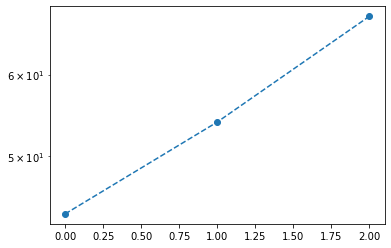

In [28]:
std0_25 = onp.std(onp.load('20wavsPSFs/Zernikes/all/Results/1nm-overshot0.25_negslope_odd.npy'))
std0_5  = onp.std(onp.load('20wavsPSFs/Zernikes/all/Results/1nm-overshot0.5_negslope_odd.npy'))
std1 = onp.std(onp.load('20wavsPSFs/Zernikes/all/Results/1nm-overshot1_negslope_odd.npy'))

stds = onp.array([std0_25, std0_5, std1])
    
stds *= 2/0.156
plt.plot(stds/5.88e-6, '--o')
plt.yscale('log')

print(stds/5.88e-6)

In [60]:
flux = 1.8e9 * 60 * 60
path = '20wavsPSFs/Zernikes/RMS_norm/'

overshot = [1,  1.0025, 1.005, 1.01, 1.05, 1.5]
overshot_names = ['0', '0.25', '0.5', '1', '5', '50']

for k in tqdm(range(len(overshot))):
    print( str(overshot[k]))
    recovered_signal = []
    for i in tqdm(range(50)):
        data = fits.open('20wavsPSFs/Zernikes/RMS_norm/correct_Epoch{}.fits'.format(i))
        image = data[1].data
        hdr = data[0].header

        ls = []
        for j in range(20):
            if j not in [1,2,6,7,8,9,15,16,17,18,19]:
                ls = onp.append(ls, hdr['zern_{}'.format(j)]*overshot[k])
            else:
                ls = onp.append(ls, 0)
                
        x0 = hdr['signal']
        input_image = make_noisy2(image, flux)
        fit =  scipy.optimize.minimize(objective2, x0,method='bfgs', args=(input_image, ls), jac = gradient2, options={'gtol': 1e-08})
        seperation_estimate = fit.x[0]

        recovered_signal = onp.append(recovered_signal, seperation_estimate)

    name = 'RMS-overshot{}'.format(overshot_names[k])
    onp.save('20wavsPSFs/Zernikes/Results/only even/'+name, recovered_signal)

  0%|          | 0/6 [00:00<?, ?it/s]

1


  0%|          | 0/50 [00:00<?, ?it/s]

1.0025


  0%|          | 0/50 [00:00<?, ?it/s]

1.005


  0%|          | 0/50 [00:00<?, ?it/s]

1.01


  0%|          | 0/50 [00:00<?, ?it/s]

1.05


  0%|          | 0/50 [00:00<?, ?it/s]

1.5


  0%|          | 0/50 [00:00<?, ?it/s]

(5,)


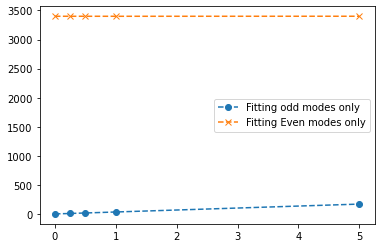

In [85]:
std0 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only odd/RMS-overshot0.npy') - planet_signal[:50])
std0_25 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only odd/RMS-overshot0.25.npy') - planet_signal[:50])
std0_5 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only odd/RMS-overshot0.5.npy') - planet_signal[:50])
std1 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only odd/RMS-overshot1.npy') - planet_signal[:50])
std5 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only odd/RMS-overshot5.npy') - planet_signal[:50])
std50 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only odd/RMS-overshot50.npy') - planet_signal[:50])

estd0 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only even/RMS-overshot0.npy') - planet_signal[:50])
estd0_25 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only even/RMS-overshot0.25.npy') - planet_signal[:50])
estd0_5 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only even/RMS-overshot0.5.npy') - planet_signal[:50])
estd1 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only even/RMS-overshot1.npy') - planet_signal[:50])
estd5 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only even/RMS-overshot5.npy') - planet_signal[:50])
estd50 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/only even/RMS-overshot50.npy') - planet_signal[:50])



x_range = onp.array([0,0.25,0.5,1,5,])#50])

stds = onp.array([std0, std0_25, std0_5, std1, std5])#, std50])
stds = stds*2/pscale
estds = onp.array([estd0, estd0_25, estd0_5, estd1, estd5])#, std50])
estds = estds*2/pscale

print(onp.shape(x_range))
plt.plot(x_range, stds/5.88e-6, '--o', label = 'Fitting odd modes only')
plt.plot(x_range, estds/5.88e-6, '--x', label = 'Fitting Even modes only')
plt.legend()

CPU times: user 54.3 s, sys: 6.02 s, total: 1min
Wall time: 11.2 s


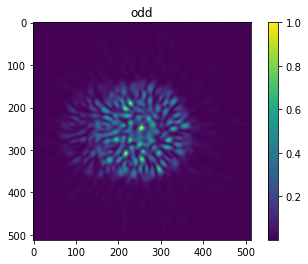

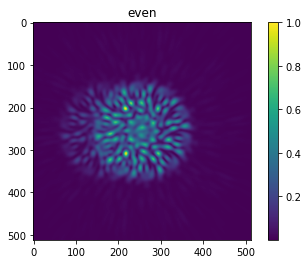

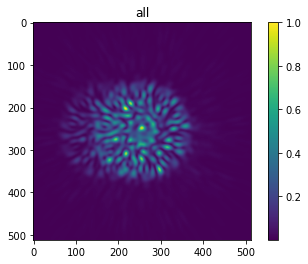

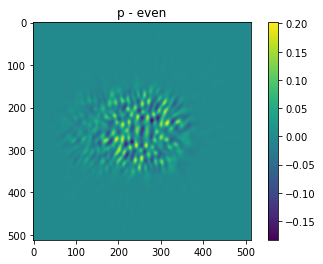

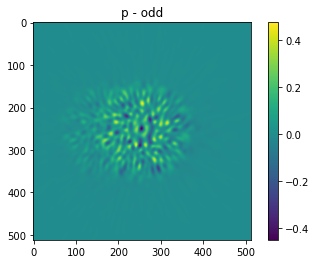

In [55]:
%%time
coeffs = onp.zeros(20)
opsys = generate_opsys(coeffs)
image_perfect = get_double_bb_psf(6 ,90 ,opsys, wavs, weights_A, weights_B)
image_perfect /= jnp.max(image_perfect)


coeffs = onp.zeros(20)
for j in range(20):
    if j in [1,2,6,7,8,9,15,16,17,18,19]:
        coeffs[j] = 1e-8
        
opsys = generate_opsys(coeffs)
image_odd = get_double_bb_psf(6 ,90 ,opsys, wavs, weights_A, weights_B)
image_odd /= jnp.max(image_odd)

coeffs = onp.zeros(20)
for j in range(20):
    if j not in [1,2,6,7,8,9,15,16,17,18,19]:
        coeffs[j] = 1e-8
        
opsys = generate_opsys(coeffs)
image_even = get_double_bb_psf(6 ,90 ,opsys, wavs, weights_A, weights_B)
image_even /= jnp.max(image_even)

coeffs = onp.ones(20)*1e-8
opsys = generate_opsys(coeffs)

image_all = get_double_bb_psf(6 ,90 ,opsys, wavs, weights_A, weights_B)
image_all /= jnp.max(image_all)


plt.figure()
plt.imshow(image_odd)
plt.title('odd')
plt.colorbar()

plt.figure()
plt.imshow(image_even)
plt.title('even')
plt.colorbar()

plt.figure()
plt.imshow(image_all)
plt.title('all')
plt.colorbar()

plt.figure()
plt.imshow(image_perfect - image_even)
plt.title('p - even')
plt.colorbar()

plt.figure()
plt.imshow(image_perfect - image_odd)
plt.title('p - odd')
plt.colorbar()

In [59]:
for j in range(20):
    if j not in [1,2,6,7,8,9,15,16,17,18,19]:
        print(morphine.zernike.zern_name(j+1))

Piston
Focus
Astigmatism 45
Astigmatism 0
Spherical
2nd Astig 0
2nd Astig 45
Tetrafoil 0
Tetrafoil 22.5


In [34]:
onp.save('20wavsPSFs/Zernikes/first6/Results/'+name, recovered_signal)

In [ ]:
zerns = [2,3,7,8,9,10]
for m in zerns:
    zern = morphine.zernike.zern_name(m)
    print(zern)

In [ ]:
flux = 1.8e9 * 60 *60

m = 18
zern = morphine.zernike.zern_name(m+1)
path = '20wavsPSFs/Zernikes/{}/1nm_norm/'.format(zern)
print(zern)

overshot = [ 1.005, 1.01, 1.025, 1.05]
overshot_names = [ '0-5', '1', '2-5', '5']

m = 1
zern = morphine.zernike.zern_name(m+1)
path = '20wavsPSFs/Zernikes/{}/1nm_norm/'.format(zern)

for k in tqdm(range(len(overshot))):
    print(zern+ ' '+ str(overshot[k]))
    recovered_signal = []
    for i in tqdm(range(50)):
        full_path = path + 'Epoch{}.fits'.format(i+50)
        data = fits.open(full_path)
        image = data[1].data
        hdr = data[0].header

        ls = []
        for j in range(20):
            ls = onp.append(ls, hdr['zern_{}'.format(j)]*(overshot[k]))
        x0 = hdr['signal']
        input_image = make_noisy2(image, flux)
        fit =  scipy.optimize.minimize(objective2, x0,method='bfgs', args=(input_image, ls), jac = gradient2, options={'gtol': 1e-08})
        seperation_estimate = fit.x[0]

        recovered_signal = onp.append(recovered_signal, seperation_estimate)

    name = '1nm-overshot{}'.format(overshot_names[k])
    onp.save('20wavsPSFs/Zernikes/{}/Estimate_Results/'.format(zern)+name, recovered_signal)

In [ ]:
new_walk_array = onp.zeros((20,101))
onp.random.seed(0)

for i in range(20):
    walk = random_walk(101, 0.2)
    new_walk_array[i,:] = walk/norm_factors[i]
    plt.plot(walk/norm_factors[i])

In [ ]:
zerns = [1,2,6,7,8,9]
zernikes = onp.zeros(20)
for i in range(len(zerns)):
    zernikes[zerns[i]] = 1e-9



In [87]:
#make images


for i in tqdm(range(101)):
    zernikes = 1e-9*onp.ones(20)
    for k in range(20):
        zernikes[k] = 1/norm_factors[k]
    
    optics = generate_opsys(zernikes)
    
    image = get_double_bb_psf(6+planet_signal[i], 90, optics, wavs, weights_A, weights_B)
    
    image_HDU = fits.ImageHDU(image)
    hdr = fits.Header()

    hdr['Signal']  = onp.float64(planet_signal[i])
    hdr['JitterX'] = 0
    hdr['JitterY'] = 0
    hdr['Roll']    = 0
    for j in range(20):
        hdr['zern_{}'.format(j)] = zernikes[j]
        
    head = fits.PrimaryHDU(header = hdr)
    hdu = fits.HDUList([head, image_HDU])
    
    name = 'Epoch{}.fits'.format(i)
    hdu.writeto('20wavsPSFs/Zernikes/all/1nm_norm/'+name)

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
#make images

for i in tqdm(range(101)):
    zernikes = 1e-9#*new_walk_array[:,i]
    zerns = [1,2,6,7,8,9]
zernikes = onp.zeros(20)
for i in range(len(zerns)):
    zernikes[zerns[i]] = 1e-9
    
    optics = generate_opsys(zernikes)
    
    image = get_double_bb_psf(6+planet_signal[i], 90, optics, wavs, weights_A, weights_B)
    
    image_HDU = fits.ImageHDU(image)
    hdr = fits.Header()

    hdr['Signal']  = onp.float64(planet_signal[i])
    hdr['JitterX'] = 0
    hdr['JitterY'] = 0
    hdr['Roll']    = 0
    for j in range(20):
        hdr['zern_{}'.format(j)] = zernikes[j]
        
    head = fits.PrimaryHDU(header = hdr)
    hdu = fits.HDUList([head, image_HDU])
    
    name = 'correct_Epoch{}.fits'.format(i)
    #hdu.writeto('20wavsPSFs/Zernikes/RMS_norm/'+name)

In [ ]:
flux = 1.8e9*60*60
path = '20wavsPSFs/Zernikes/RMS_norm/'

recovered_signal = []
for i in tqdm(range(101)):
    data = fits.open('20wavsPSFs/Zernikes/RMS_norm/correct_Epoch{}.fits'.format(i))
    image = data[1].data
    hdr = data[0].header

    x0 = hdr['signal']
    #x0 = [0]
    input_image = make_noisy2(image, flux)
    fit =  scipy.optimize.minimize(objective, x0,method='bfgs', args=(input_image), jac = gradient, options={'gtol': 1e-08})
    seperation_estimate = fit.x[0]

    recovered_signal = onp.append(recovered_signal, seperation_estimate)

name = '1hr_phot_RMS_norm_nm_known_sig'
onp.save('20wavsPSFs/Zernikes/Results/'+name, recovered_signal)

In [ ]:
data1 = onp.load('20wavsPSFs/Zernikes/Results/phot_RMS_norm_nm_unknown_sig.npy')
data2 = onp.load('20wavsPSFs/Zernikes/Results/phot_RMS_norm_nm.npy')
plt.plot(data1 - planet_signal, 'x', label = 'Unknown signal')
plt.plot(data2 - planet_signal, 'x', label = 'Known signal')
#plt.plot(-new_walk_array[0,:]/500-new_walk_array[1,:]/500, label = 'Scaled and sign flipped ')
plt.xlabel('Epoch')
plt.ylabel('STD')
plt.legend()

In [ ]:
#print(jnp.std(recovered_signal - planet_signal[:50])*(2/pscale))
recovered_signal = onp.load('20wavsPSFs/No Errors/1001/Results/flux1000000000.0makenoisy.npy')
std = jnp.std(recovered_signal)*(2/pscale)
data = fits.open('20wavsPSFs/No Errors/1001/Epoch0.fits')
image = data[1].data
flux = 1.8e9
rao = get_cramer(image, flux)
print(std)
print(rao)
print(std/rao)
plt.imshow(image)


In [ ]:
powers = onp.linspace(0,15,16)
raos = []
for i in range(16):
    flux = 1*10**powers[i]
    rao = get_cramer(image, flux)
    raos = onp.append(raos, rao)
    
plt.plot(raos)
plt.yscale('log')

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  SIGNAL  = 4.99013364214135E-07                                                  JITTERX =                    0                                                  JITTERY =                    0                                                  ROLL    =                    0                                                  ZERN_0  = 2.08499615327217E-09                                                  ZERN_1  = 5.48590849158984E-10                                                  ZERN_2  = 1.04374936041336E-11                                                  ZERN_3  =                  0.0                                                  ZERN_4  = 2.42622235648924E-10          

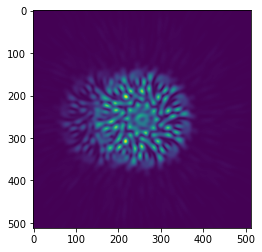

In [36]:
i = 26
data = fits.open('20wavsPSFs/Zernikes/RMS_norm/correct_Epoch{}.fits'.format(i))
image = data[1].data
hdr = data[0].header
print(hdr)
plt.imshow(image)

In [ ]:
flux = 1.8e9 * 60 * 60
path = '20wavsPSFs/Zernikes/RMS_norm/'

recovered_signal = []
for i in tqdm(range(50)):
    data = fits.open('20wavsPSFs/Zernikes/RMS_norm/correct_Epoch{}.fits'.format(i))
    image = data[1].data
    hdr = data[0].header
    
    ls = []
    for j in range(20):
        ls = onp.append(ls, hdr['zern_{}'.format(j)]*(1-0.005))
    x0 = hdr['signal']
    input_image = make_noisy2(image, flux)
    fit =  scipy.optimize.minimize(objective2, x0,method='bfgs', args=(input_image, ls), jac = gradient2, options={'gtol': 1e-08})
    seperation_estimate = fit.x[0]

    recovered_signal = onp.append(recovered_signal, seperation_estimate)

name = '2604_1hrknownZernike_minus0_5'
onp.save('20wavsPSFs/Zernikes/Results/'+name, recovered_signal)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  SIGNAL  =                  0.0                                                  JITTERX =                    0                                                  JITTERY =                    0                                                  ROLL    =                    0                                                  ZERN_0  =                  0.0                                                  ZERN_1  = 2.50982318271119E-10                                                  ZERN_2  = 2.50982318271119E-10                                                  ZERN_3  =                  0.0                                                  ZERN_4  =                  0.0          

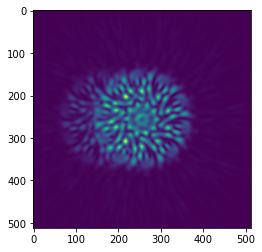

In [32]:
data = fits.open('20wavsPSFs/Zernikes/first6/1nm_norm/Epoch0.fits')
header = data[0].header
image = data[1].data

ls = []
for j in range(20):
    ls = onp.append(ls, header['zern_{}'.format(j)]*1)

plt.imshow(image)
print(header)
print(ls)

[84.57422573 16.89968224  8.21130431  3.50295566  1.16241128  3.87533815
  8.79469201 17.19525371 85.18336882]
5.88559103869904e-06
[4.97769305e-04 9.94646184e-05 4.83283791e-05 2.06169644e-05
 6.84147741e-06 2.28086555e-05 5.17619605e-05 1.01204231e-04
 5.01354472e-04]


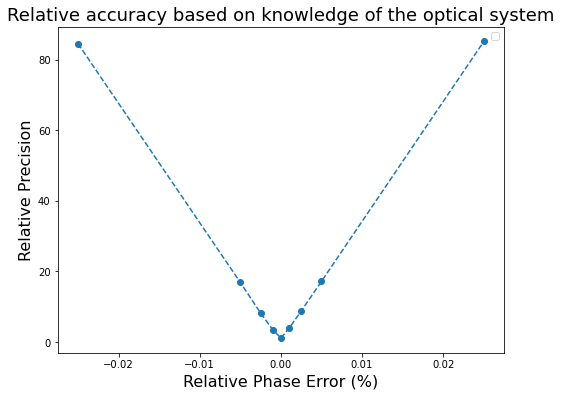

In [66]:
percent   = onp.array([0.975, 0.995, 0.9975, 0.999, 1, 1.001, 1.0025, 1.005, 1.025]) -1
std_m2_5  = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2604_1hrknownZernike_minus2_5.npy'))
std_m0_5  = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2604_1hrknownZernike_minus0_5.npy'))
std_m0_25 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2604_1hrknownZernike_minus0_25.npy'))
std_m0_1  = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2604_1hrknownZernike_minus0_1.npy'))
std       = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2604_1hrknownZernike.npy'))
std_p0_1  = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2604_1hrknownZernike_plus0_1.npy'))
std_p0_25 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2604_1hrknownZernike_plus0_25.npy'))
std_p0_5  = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2604_1hrknownZernike_plus0_5.npy'))
std_p2_5  = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2604_1hrknownZernike_plus2_5.npy'))

stds = onp.array([std_m2_5, std_m0_5, std_m0_25, std_m0_1, std, std_p0_1, std_p0_25, std_p0_5, std_p2_5])
stds = stds*2/pscale

flux  = 1.8e9*60*60
data  = fits.open('20wavsPSFs/Zernikes/RMS_norm/correct_Epoch0.fits')
image = data[1].data
rao   = get_cramer(image, flux)

print(stds/rao)
print(rao)
print(stds)

plt.figure(figsize = (8,6))
plt.plot(percent, stds/rao, '--o')
plt.xlabel('Relative Phase Error (%)', fontsize = 16)
plt.ylabel('Relative Precision', fontsize = 16)
plt.title('Relative accuracy based on knowledge of the optical system', fontsize = 18)

#first6_std_p0_1  = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2604_1hrknownZernike_plus0_1.npy'))
first6_std_p0_25 = jnp.std(onp.load('20wavsPSFs/Zernikes/first6/Results/1nm-overshot0-25.npy') - planet_signal)
first6_std_p0_5  = jnp.std(onp.load('20wavsPSFs/Zernikes/first6/Results/1nm-overshot0-5.npy') - planet_signal)
first6_std_p1  = jnp.std(onp.load('20wavsPSFs/Zernikes/first6/Results/1nm-overshot1.npy') - planet_signal)
first6_std_p2_5  = jnp.std(onp.load('20wavsPSFs/Zernikes/first6/Results/1nm-overshot2-5.npy') - planet_signal)
first6_std_p5  = jnp.std(onp.load('20wavsPSFs/Zernikes/first6/Results/1nm-overshot5.npy') - planet_signal)
first6_std_p50  = jnp.std(onp.load('20wavsPSFs/Zernikes/first6/Results/1nm-overshot50.npy') - planet_signal)

xrange = [0.25, 0.5, 1, 2.5, 5, 50]
stds2 = onp.array([first6_std_p0_25, first6_std_p0_5, first6_std_p1, first6_std_p2_5, first6_std_p5, first6_std_p50 ])
stds2 = stds2*2/pscale

#plt.plot(xrange, stds2/rao, '--x', label = 'first 6 Odd modes only ')

first11_std_p0_25 = jnp.std(onp.load('20wavsPSFs/Zernikes/first11/Results/1nm-overshot0-25.npy') - planet_signal)
first11_std_p0_5  = jnp.std(onp.load('20wavsPSFs/Zernikes/first11/Results/1nm-overshot0-5.npy') - planet_signal)
first11_std_p1  = jnp.std(onp.load('20wavsPSFs/Zernikes/first11/Results/1nm-overshot1.npy') - planet_signal)
first11_std_p2_5  = jnp.std(onp.load('20wavsPSFs/Zernikes/first11/Results/1nm-overshot2-5.npy') - planet_signal)
first11_std_p5  = jnp.std(onp.load('20wavsPSFs/Zernikes/first11/Results/1nm-overshot5.npy') - planet_signal)
first11_std_p0  = jnp.std(onp.load('20wavsPSFs/Zernikes/first11/Results/1nm-overshot0.npy') - planet_signal)
first11_std_p50  = jnp.std(onp.load('20wavsPSFs/Zernikes/first11/Results/1nm-overshot50.npy') - planet_signal)


xrange = [0, 0.25, 0.5, 1, 2.5, 5, 50]
stds3 = onp.array([first11_std_p0, first11_std_p0_25, first11_std_p0_5, first11_std_p1, first11_std_p2_5, first11_std_p5, first11_std_p50 ])
stds3 = stds3*2/pscale

#plt.plot(xrange, stds3/rao, '--o', label = 'first 11 Odd modes only ')
#plt.xlim([0,10])
plt.legend()

0.15271750670994214
0.08368451129063406
[5.96085887 3.16650044 1.80276665 1.41216116 1.07287835 1.46445658
 1.30605863 1.27041844 1.95791675 3.30715066 5.66763498]


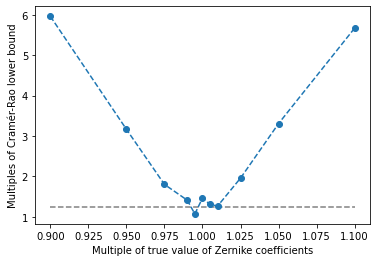

In [24]:
percent = [0.9,0.95,0.975,0.99,0.995,1,1.005,1.01,1.025,1.05,1.10]

std_m10  = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2504_knownZernike_minus10.npy'))
std_m5   = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2504_knownZernike_minus5.npy'))
std_m2_5 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2504_knownZernike_minus2_5.npy'))
std_m1   = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2504_knownZernike_minus1.npy'))
std_m0_5 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2504_knownZernike_minus0_5.npy'))
std_0    = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2504_knownZernike.npy'))
std_p0_5 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2504_knownZernike_plus0_5.npy'))
std_p1   = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2504_knownZernike_plus1.npy'))
std_p2_5 = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2504_knownZernike_plus2_5.npy'))
std_p5   = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2504_knownZernike_plus5.npy'))
std_p10  = jnp.std(onp.load('20wavsPSFs/Zernikes/Results/2504_knownZernike_plus10.npy'))


stds = onp.array([std_m10, std_m5, std_m2_5, std_m1, std_m0_5, std_0, std_p0_5, std_p1, std_p2_5, std_p5, std_p10])
stds = stds*2/pscale
print(std_p2_5/3.53e-4)
print(std_m0_5/3.53e-4)
print(stds/3.53e-4)
plt.plot(percent, stds/3.53e-4, '--o')
#plt.yscale('log')
plt.ylabel('Multiples of Cramér-Rao lower bound')
plt.xlabel('Multiple of true value of Zernike coefficients')
plt.hlines(1.25, 0.9,1.1, ls = '--', color = 'grey')
#plt.yscale('log')

In [ ]:
ls = []
for j in range(20):
    if j== 6:
        ls = onp.append(ls, 0)
        continue
    ls = onp.append(ls, hdr['zern_{}'.format(j)])
    
print(ls)
print(ls[6])

In [ ]:
flux = 1.8e9# * 60 * 60
path = '20wavsPSFs/Zernikes/RMS_norm/'

#fitting coma Y
estimated_tiltY = []
estimated_tiltX = []
recovered_signal = []
for i in tqdm(range(50)):
    data = fits.open('20wavsPSFs/Zernikes/RMS_norm/correct_Epoch{}.fits'.format(i))
    image = data[1].data
    hdr = data[0].header
    
    ls = []
    for j in range(20):
        if j == 2:
            ls = onp.append(ls, 0)
            continue
        if j == 3:
            ls = onp.append(ls, 0)
            continue    
        
        ls = onp.append(ls, hdr['zern_{}'.format(j)])
    ls = jnp.array(ls)
    x0 = jnp.array([hdr['signal'], hdr['zern_2']*1.05, hdr['zern_3']*1.05])
    input_image = make_noisy2(image, flux)
    fit =  scipy.optimize.minimize(objective4, x0,method='bfgs', args=(input_image, ls), jac = gradient4, options={'gtol': 1e-10})
    seperation_estimate = fit.x[0]
    tiltY_estimate = fit.x[1]
    tiltX_estimate = fit.x[2]


    recovered_signal = onp.append(recovered_signal, seperation_estimate)
    estimated_tiltY = onp.append(estimated_tiltY, tiltY_estimate)
    estimated_tiltX = onp.append(estimated_tiltX, tiltX_estimate)


name = 'tilt_signal_5per'
name2 = '2504_unknown_tiltYX_abY_3_1per'
name3 = '2504_unknown_tiltYX_abX_3_1per'
onp.save('20wavsPSFs/Zernikes/Results/'+name, recovered_signal)
onp.save('20wavsPSFs/Zernikes/Results/'+name2, estimated_comaY)
onp.save('20wavsPSFs/Zernikes/Results/'+name3, estimated_comaX)

In [ ]:
print(jnp.std(estimated_tiltX))
print(jnp.mean(estimated_tiltX))
print(jnp.std(recovered_signal)*2/pscale)
print(jnp.mean(recovered_signal))
print(morphine.zernike.zern_name(3))
print(get_cramer(image, 1.8e9))

plt.figure(figsize = (12,8))
plt.plot(estimated_tiltX)
#plt.plot(new_walk_array[6,:3]*1e-9 - estimated_comaY)
plt.plot(new_walk_array[3,:50]*1e-9*1.05 )#- estimated_comaY)


In [ ]:
print(jnp.std(estimated_coma))
print(jnp.mean(estimated_coma))
print(jnp.std(recovered_signal))
print(jnp.mean(recovered_signal))
print(morphine.zernike.zern_name(8))

In [ ]:
print(jnp.std(recovered_signal - planet_signal)*(2/pscale))
#data = fits.open('20wavsPSFs/Zernikes/Comas/1st&2nd/correct_Epoch0.fits')
data = fits.open('20wavsPSFs/Zernikes/RMS_norm/correct_Epoch0.fits')
image = data[1].data
flux = 1.8e9#*60*60
print(get_cramer(image, flux))
plt.imshow(image)
print(jnp.std(recovered_signal - planet_signal)*(2/pscale)/get_cramer(image, flux))

In [ ]:
print(stop)

In [ ]:
data = fits.open('20wavsPSFs/Zernikes/RMS/correct_Epoch0.fits')
unaberrated_PSF = data[1].data

plt.figure(figsize = (24,8))
plt.subplot(1,3,1)
plt.imshow(unaberrated_PSF)
plt.title('Unaberrated PSF')
plt.colorbar()

largest_sum = 0
index = 0
RMS = 0
for i in range(101):
    current_sum = jnp.sum(walk_array[:,i])
    if current_sum > largest_sum:
        largest_sum = current_sum
        index = i
        RMS = jnp.sqrt((1/(20)) * jnp.sum(walk_array[:,i]**2))

print(index, largest_sum)

data = fits.open('20wavsPSFs/Zernikes/RMS/correct_Epoch{}.fits'.format(index))
aberrated_PSF = data[1].data

plt.subplot(1,3,2)
plt.imshow(aberrated_PSF)
plt.title('Aberrated PSF')
plt.xlabel('Sum total: {:.2f}'.format(largest_sum) + '\n RMS: {:.2f}'.format(RMS))
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(aberrated_PSF - unaberrated_PSF)
plt.title('Difference')
plt.colorbar()

In [ ]:
from scipy.ndimage import center_of_mass

In [ ]:
print(onp.argmax(unaberrated_PSF))
print(onp.argmax(aberrated_PSF))

brightest_pix = onp.argmax(unaberrated_PSF)
x = brightest_pix % 512
y = int((brightest_pix - x)/512)
print(x,y)

print(center_of_mass(unaberrated_PSF))
print(center_of_mass(aberrated_PSF))

print((center_of_mass(unaberrated_PSF)[0] - center_of_mass(aberrated_PSF)[0]))
print((center_of_mass(unaberrated_PSF)[1] - center_of_mass(aberrated_PSF)[1]))

In [ ]:
def com_difference(image1, image2):
    image_1x, image_1y = center_of_mass(image1)
    image_2x, image_2y = center_of_mass(image2)

    return onp.abs(image_1x - image_2x), onp.abs(image_1y - image_2y)

In [ ]:
print(com_difference(unaberrated_PSF, aberrated_PSF))

In [ ]:
rms_vec = []
com_diff_vec = []
for i in tqdm(range(101)):
    data = fits.open('20wavsPSFs/Zernikes/RMS/correct_Epoch{}.fits'.format(i))
    aberrated_PSF =  data[1].data
    
    x,y = com_difference(unaberrated_PSF, aberrated_PSF)
    dist = onp.sqrt(x**2 + y**2)
    
    rms = jnp.sqrt((1/(20)) * jnp.sum(walk_array[:,i]**2))
    
    rms_vec = onp.append(rms_vec, rms)
    com_diff_vec = onp.append(com_diff_vec, dist)

plt.plot(rms_vec, label = 'RMS')
plt.plot(com_diff_vec, label = 'COM difference')
plt.ylabel('aberration (nm) (blue line) \n Centre of mass difference (pix) (orange line)')
plt.xlabel('Epoch')
plt.legend()

In [ ]:
print(stop)

In [ ]:
for i in tqdm(range(101)):
    zernikes = 1e-9*walk_array[:,i]
    optics = generate_opsys(zernikes)
    
    image = get_double_bb_psf(6+planet_signal[i], 90, optics, wavs, weights_A, weights_B)
    
    image_HDU = fits.ImageHDU(image)
    hdr = fits.Header()

    hdr['Signal']  = onp.float64(planet_signal[i])
    hdr['JitterX'] = 0
    hdr['JitterY'] = 0
    hdr['Roll']    = 0
    for j in range(20):
        hdr['zern_{}'.format(j)] = zernikes[j]
        
    head = fits.PrimaryHDU(header = hdr)
    hdu = fits.HDUList([head, image_HDU])
    
    name = 'correct_Epoch{}.fits'.format(i)
    hdu.writeto('20wavsPSFs/Zernikes/RMS/'+name)

In [ ]:

flux = 1.8e9
path = '20wavsPSFs/Zernikes/RMS/'

recovered_signal = []
for i in tqdm(range(101)):
    data = fits.open('20wavsPSFs/Zernikes/RMS/correct_Epoch{}.fits'.format(i))
    image = data[1].data
    hdr = data[0].header

    x0 = hdr['signal']
    input_image = make_noisy2(image, flux)
    fit =  scipy.optimize.minimize(objective, x0,method='bfgs', args=(input_image), jac = gradient, options={'gtol': 1e-08})
    seperation_estimate = fit.x[0]

    recovered_signal = onp.append(recovered_signal, seperation_estimate)

name = 'phot_RMSnm'
onp.save('20wavsPSFs/Zernikes/Results/'+name, recovered_signal)

In [ ]:
print(jnp.std(recovered_signal))
print(jnp.std(recovered_signal - planet_signal))

test = onp.load('20wavsPSFs/No Errors/1001/Results/flux1800000000.0makenoisy2.npy')
print(jnp.std(test))



In [ ]:
flux = 1.8e9
path = '20wavsPSFs/Zernikes/RMS/'

recovered_signal = []
for i in tqdm(range(101)):
    data = fits.open('20wavsPSFs/Zernikes/RMS/correct_Epoch{}.fits'.format(i))
    image = data[1].data
    hdr = data[0].header
    
    ls = []
    for j in range(20):
        ls = onp.append(ls, hdr['zern_{}'.format(j)])
    x0 = hdr['signal']
    input_image = make_noisy2(image, flux)
    fit =  scipy.optimize.minimize(objective2, x0,method='bfgs', args=(input_image, ls), jac = gradient2, options={'gtol': 1e-08})
    seperation_estimate = fit.x[0]

    recovered_signal = onp.append(recovered_signal, seperation_estimate)

name = 'phot_RMSnm_knownZernikes'
onp.save('20wavsPSFs/Zernikes/Results/'+name, recovered_signal)

In [ ]:
print(jnp.std(recovered_signal - planet_signal)*(2/pscale))
data = fits.open('20wavsPSFs/Zernikes/RMS/correct_Epoch0.fits')
image = data[1].data
flux = 1.8e9
print(get_cramer(image, flux))

print(jnp.std(recovered_signal - planet_signal)*(2/pscale)/get_cramer(image, flux))

In [ ]:
for i in range(20):
    print(morphine.zernike.zern_name(i+1))

zernikes = onp.zeros(20)
zernikes[6] = 38*1e-9
zernikes[7] = 38*1e-9
zernikes[15] = 38*1e-9
zernikes[16] = 38*1e-9

osys = generate_opsys(zern_coeffs = zernikes)

for i in tqdm(range(101)):
    image = get_double_bb_psf(6+planet_signal[i], 90, osys, wavs, weights_A, weights_B)
    
    # Create .fits
    image_HDU = fits.ImageHDU(image)
    hdr = fits.Header()

    hdr['Signal']  = onp.float64(planet_signal[i])
    hdr['JitterX'] = 0
    hdr['JitterY'] = 0
    hdr['Roll']    = 0
    for j in range(20):
        hdr['zern_{}'.format(j)] = zernikes[j]
        
    head = fits.PrimaryHDU(header = hdr)
    hdu = fits.HDUList([head, image_HDU])

    # Save Image
    name = 'correct_Epoch{}.fits'.format(i)
    hdu.writeto('20wavsPSFs/Zernikes/Comas/1st&2nd/'+name)



In [ ]:
# next try fitting with the coma as well :)

In [ ]:
#################
# Create images #
# with zernikes #
#################

for l in tqdm(range(1)):
    k = 24
    for j in tqdm(range(20)):
        zernikes = onp.zeros(20)
        zernikes[j] = 1e-9*onp.array(k+1)  
        zernikes = jnp.array(zernikes)
        zern = morphine.zernike.zern_name(j+1)
        osys = generate_opsys(zern_coeffs = zernikes)
        print('Creating ' + str(k+1)+'nm of ' +str(zern)+ ' aberration time series now:')
        for i in tqdm(range(101)):
            # Calc image
            image = get_double_bb_psf(6+planet_signal[i],90,osys, wavs, weights_A, weights_B)

            # Create .fits
            image_HDU = fits.ImageHDU(image)
            hdr = fits.Header()

            hdr['Signal']  = onp.float64(planet_signal[i])
            hdr['JitterX'] = 0
            hdr['JitterY'] = 0
            hdr['Roll']    = 0
            for jj in range(20):
                if jj != j:
                    hdr['zern_{}'.format(jj)] = 0
                else:
                    hdr['zern_{}'.format(jj)] = onp.float64(k+1)

            head = fits.PrimaryHDU(header = hdr)
            hdu = fits.HDUList([head, image_HDU])

            # Save Image
            name = 'correct_Epoch{}.fits'.format(i)
            zern = morphine.zernike.zern_name(j+1)
            hdu.writeto('20wavsPSFs/Zernikes/'+str(zern)+'/{}nm/'.format(k+1)+name)

In [ ]:
#################################
# model without zernike fitting #
# and just photon noise         #
#################################


flux = 1.8e9
path = '20wavsPSFs/Zernikes/'

zerns = ['Tilt X', 'Coma Y', '2nd Astig 0', '2nd coma Y']

for i in tqdm(range(len(zerns))):
    zern = zerns[i]
    print('Calculating fits for ' + zern +'...')
    for jj in tqdm(range(1)):
        j = jj+24
        print('Calculating aberration of {}nm...'.format(j+1))
        recovered_signal = []
        for k in tqdm(range(60)):
            data = fits.open(path+zern+'/{}nm/'.format(j+1) + 'correct_Epoch{}.fits'.format(k) )
            image = data[1].data
            hdr = data[0].header
            
            x0 = hdr['signal']
            input_image = make_noisy2(image, flux)
            fit =  scipy.optimize.minimize(objective, x0,method='bfgs', args=(input_image), jac = gradient, options={'gtol': 1e-08})
            seperation_estimate = fit.x[0]
            
            recovered_signal = onp.append(recovered_signal, seperation_estimate)
        
        name = 'phot_{}nm_{}'.format(j+1, zern)
        onp.save('20wavsPSFs/Zernikes/Results/'+name, recovered_signal)


    

In [ ]:
abs_errors = []

vmin,vmax = -5e-6,5e-6
#fig, axes = plt.subplots(2,4,figsize=(20,16))


for i in range(20):
    zern = morphine.zernike.zern_name(i+1)
    data1 = fits.open('20wavsPSFs/Zernikes/'+zern+'/1nm/correct_Epoch0.fits')
    image1 = data1[1].data
    
    data2 = fits.open('20wavsPSFs/Zernikes/'+zern+'/4nm/correct_Epoch0.fits')
    image2 = data2[1].data
    
    abs_error = jnp.sum(jnp.abs(image2-image1))
    abs_errors = onp.append(abs_errors, abs_error)
    plt.figure()
    plt.imshow(image2-image1, cmap = 'seismic')
    plt.title(zern)
    plt.xlabel('{:.3e}'.format(abs_error))
    plt.colorbar()
    
# fig, axes = plt.subplots(10,2,figsize=(40,32))

# for i, ax in enumerate(axes.ravel()):
    
#     zern = morphine.zernike.zern_name(i+1)
#     data1 = fits.open('20wavsPSFs/Zernikes/'+zern+'/1nm/correct_Epoch0.fits')
#     image1 = data1[1].data
    
#     data2 = fits.open('20wavsPSFs/Zernikes/'+zern+'/4nm/correct_Epoch0.fits')
#     image2 = data2[1].data

#     ax.imshow(image2-image1)
#     ax.set_title(zern)
#     ax.set_xlabel('Absolute error: {:.3e}'.format(abs_error))

In [ ]:
data = fits.open('20wavsPSFs/No Errors/Epoch100.fits')
image = data[1].data
std_x, std_y = cramer_rao_bound(image*flux)
std_sec_x = std_x*jnp.sqrt(3) # magic number is the binary contrast ratio
std_sec_y = std_y*jnp.sqrt(3)

std_sep_x = jnp.sqrt(std_x**2+std_sec_x**2)
std_sep_y = jnp.sqrt(std_y**2+std_sec_y**2)
std_sep = onp.mean([std_sep_x,std_sep_y])
print(std_sep)
cramer_rao_lower_bound = std_sep

In [ ]:
means = []

planet_signal30 = []
for i in range(30):
    data = fits.open('20wavsPSFs/Zernikes/Pentafoil X/1nm/correct_Epoch{}.fits'.format(i))
    hdr = data[0].header
    sig = hdr['signal']
    planet_signal30 = onp.append(planet_signal30, sig)

fig, axes = plt.subplots(5,4,figsize=(48,45))    
    
for j, ax in enumerate(axes.ravel()):
#for j in range(20):
    zern = morphine.zernike.zern_name(j+1)
    stds = []
    cramers = []
    
    for i in range(5):
        if i == 4:
            i = 24
        
#         data = onp.load('20wavsPSFs/Zernikes/Results/phot_{}nm_{}.npy'.format(i+1, zern))
#         std = jnp.std(data - planet_signal30) * (2/pscale)
#         stds = onp.append(stds,std)
        
        data = fits.open('20wavsPSFs/Zernikes/{}/{}nm/correct_Epoch0.fits'.format(zern, i+1))
        image = data[1].data
        rao = get_cramer(image,flux)
        cramers = onp.append(cramers, rao)
        
#     mean = jnp.mean(stds)
#     means =  onp.append(means, mean)
    #plt.figure()
    #plt.plot([1,2,3,4],stds,'--x', label = 'Std', color = 'blue')
    ax.plot([1,2,3,4,25], cramers, '--v', label = 'Cramer rao lower bound', color = 'grey')
    ax.hlines(cramer_rao_lower_bound,1,25, ls = ':', color = 'grey', label = 'cramer rao bound (unaberrated PSF)')
#     plt.xlabel('aberration (nm) \n mean: {:.3e}'.format(mean))
    ax.set_xlabel('aberration (nm)')
    ax.set_ylabel('Seperation error (pix)')
    ax.set_yscale('log')
    ax.set_xscale('log')
#     plt.ylim([2.5e-4,5.5e-4])
    ax.set_title(zern)
    ax.legend()

plt.savefig('test222.pdf')

In [ ]:
jnegs = [7,8,9,10,16,17,18,19]
comas = [7,8,16,17]
flux = 1.8e9

for i in range(len(comas)):
    print(morphine.zernike.zern_name(comas[i]))
    
coma_coeffs = onp.zeros((20))
#for i in range(4):
    #coma_coeffs[comas[i]] = 1e-9
coma_coeffs[comas[1]] = 1e-9   
    
#cramers = []    
#cramers_1st = []
#cramers_y = []
cramers_x = []
for i in tqdm(range(25)):
    coeffs = 5*i*coma_coeffs
    opsys = generate_opsys(coeffs)
    image = get_double_bb_psf(6,90,opsys, wavs, weights_A, weights_B)
    rao = get_cramer(image, flux)
    cramers_x = onp.append(cramers_x, rao)

plt.imshow(image)

In [ ]:
xrange = onp.linspace(0,24*5,25)
plt.plot(xrange, cramers, '--o', label = '1st and 2nd coma')
plt.plot(xrange, cramers_1st, '--x', label = 'Just 1st coma')
plt.plot(xrange, cramers_y, '--v', label = 'Just 1st coma Y')
plt.plot(xrange, cramers_x, '--^', label = 'Just 1st coma X')
plt.yscale('log')
plt.xlabel('Magnitude of aberation (nm)')
plt.ylabel('Seperation error (pix)')
plt.legend()

In [ ]:
coma_coeffs = onp.zeros((20))
for i in range(4):
    coma_coeffs[comas[i]] = 38*1e-9
    
opsys1 = generate_opsys(coma_coeffs)    
    
image_all_coma = get_bb_psf(0,90,opsys1, wavs, weights_A)

plt.figure()
plt.imshow(image_all_coma)
plt.title('PSF - all comas - 38nm')

coma_coeffs = onp.zeros((20))
for i in range(2):
    coma_coeffs[comas[i]] = 60*1e-9
    
opsys2 = generate_opsys(coma_coeffs)    
image_1st_coma = get_bb_psf(0,90,opsys2, wavs, weights_A)

plt.figure()
plt.imshow(image_1st_coma)
plt.title('PSF - 1st order comas - 60nm')

coma_coeffs = onp.zeros((20))
coma_coeffs[comas[0]] = 82*1e-9
opsys3 = generate_opsys(coma_coeffs)    
image_Y_coma = get_bb_psf(0,90,opsys3, wavs, weights_A)

plt.figure()
plt.imshow(image_Y_coma)
plt.title('PSF - Y coma - 82nm')

coma_coeffs = onp.zeros((20))
coma_coeffs[comas[1]] = 100*1e-9
opsys4 = generate_opsys(coma_coeffs)    
image_Y_coma = get_bb_psf(0,90,opsys4, wavs, weights_A)

plt.figure()
plt.imshow(image_Y_coma)
plt.title('PSF - X coma - 100nm')

In [ ]:
plt.scatter(abs_errors, means)
plt.xlabel('Sum of absolute errors of 1nm of each zernike mode')
plt.ylabel('Mean of std of the first 4nm')

In [ ]:
zernikes = morphine.zernike.zernike_basis(NZ,npix=num_pix,outside=0.0) 
print(type(zernikes[0]))

In [ ]:
from jax import jacfwd


In [ ]:
def delete_this(coefficients):
    optic = generate_opsys(coefficients)
    image = get_bb_psf(0,0,optic, wavs, weights_A)
    return image

In [ ]:
jac_zernikes = jacfwd(delete_this)
jacobian = jac_zernikes(jnp.zeros_like(jnp.zeros(NZ)))


In [ ]:
fig, axes = plt.subplots(4,5,figsize=(20,16))

vmin, vmax = onp.nanmin(jacobian),onp.nanmax(jacobian)

for j, ax in enumerate(axes.ravel()):
    ax.imshow(jacobian[:,:,j],vmin=vmin,vmax=vmax,cmap='seismic')
    ax.set_title(morphine.zernike.zern_name(j+1))
    ax.set_xticks([])
    ax.set_yticks([])


In [ ]:
zerns = ['Tilt X', 'Coma Y', '2nd Astig 0', '2nd coma Y']

tiltx = onp.load('20wavsPSFs/Zernikes/Results/phot_25nm_Tilt X.npy')
comay = onp.load('20wavsPSFs/Zernikes/Results/phot_25nm_Coma Y.npy')
astig = onp.load('20wavsPSFs/Zernikes/Results/phot_25nm_2nd Astig 0.npy')
comay2 = onp.load('20wavsPSFs/Zernikes/Results/phot_25nm_2nd coma Y.npy')

things = [tiltx, comay, astig, comay2]
relevant_means = [means[1], means[6], means[11], means[16]] # means of low aberrations of above zerns

flux = 1.8e9

stds = []
signal60 = planet_signal[:60]
cramer = []
lower_cramers = []

for i in range(4):
    cram = []
    for j in range(4):
        data = fits.open('20wavsPSFs/Zernikes/{}/{}nm/correct_Epoch0.fits'.format(zerns[i], j+1))
        image = data[1].data
        rao = get_cramer(image,flux)
        cram = onp.append(cram, rao)
    mean_cram = onp.mean(cram)
    lower_cramers = onp.append(lower_cramers, mean_cram)
    
    
for i in range(4):
    std = jnp.std(things[i] - signal60) *(2/pscale)
    stds = onp.append(stds, std)
    data = fits.open('20wavsPSFs/Zernikes/{}/25nm/correct_Epoch0.fits'.format(zerns[i]))
    image = data[1].data
    
    rao = get_cramer(image, flux)
    cramer = onp.append(cramer, rao)

plt.figure(figsize = (8,6))
plt.plot(zerns, stds, 'x', label = '25nm')
plt.plot(zerns, relevant_means, 'o', color = 'orange', label = 'mean(1-4nm)*')
plt.plot(zerns, cramer, ls = ':', color = 'grey', label = 'Cramer-Rao lower bound (25nm)')
plt.plot(zerns, lower_cramers, ls = '--', color = 'grey', label = 'Cramer-Rao lower bound mean(1-4nm)*')
plt.title('A selection of 25nm zernike modes')
plt.ylabel('Seperation error (pix)')
plt.yscale('log')
plt.legend()

# Notes on the above image

## Aside:
The 25nm data points used a sample size of 60. The data points representing aberrations of 1-4nm used a sample size of 30 fitting evalutations. The std varied somewhat between them, so the mean was taken to reduce the variability of the std. This isn't very sound, but as the differences between between the stds of aberrations of 1 through 4 nm would be minimal compared to the difference between them and a 25nm aberration - I am taking the assumption that any information gained from the above figure would be very similar to a more rigorous data collection. I only did this as the lower aberrations were already calculated and computation time is a limiting factor to this data analysis.

Also - obviously the fact that a line plot is used the Cramer-Rao lower bound doesn't make sense. It is a line instead of points as I believe this helps visually simplify the diagram and makes reading it clearer

## Choice of zernike modes

The toliman psf is immune/resilient to some zernike mode - to first order. The difference between so called first and second order zernike modes is that the jacobian of second order modes are one to two orders of magnitude lower than first order modes. Here Tilt X, Coma Y, and 2nd coma Y are first order modes, and 2nd astig 0 is a second order mode. Furthermore Tilt X was chosen as the recovered signal should be immune to this mode. Coma Y and 2nd Coma Y were chosen as they should mostly act perpendicular to the signal (which is soley in the x direction in the generated images). 2nd astig 0 doesn't act purely in either direction so it was also included. Finally Coma Y and 2nd Coma Y were both included to see if there are any notable differences between the two.

## Cramer-Rao lower bound
As the psf changes due to optical distortions, so does the Cramer-rao lower bound. Initially interesting, this can both increase and decrease the lower bound. This is of course because the toliman PSF isn't purely optimised for a small cramer-rao bound. 

For the first order modes, the Cramer-Rao lower bound is appromiately equal or lower as the magnitude of the aberration increases. Inversely, the Cramer-Rao lower bound increases with (the one) second order mode. This could be just noise - or a real relationship. I need to investigate further.


## Results
As expected, the Tilt X mode doesn't significantly change with magnitude. Although the STD is lower for the larger magnitude this is likely due to more samples taken? Or maybe not I'm not sure. 

For both Coma Y and 2nd Coma Y, the larger aberration has a significantly worse result. This is likely due to the fact that coma "smears" the PSF making it harder for the fitting function. It should be noted that I was not trying to fit to zernikes and was only fitting separation. This might change if zernike modes are included in the fitting function - at the cost of computation time.

For 2nd astig 0, the distance between the std and the lower bound looks approximately equal on visual inspection. Perhaps if a zernike mode is found that has this relation but lowers the cramer-rao bound the optical system could have this aberration introduced and increase accuracy. I suspect this isn't possible - but it would be very cool if it did. Even if such a thing was found -  it is not guarenteed that a physical modification to the optical system could be done that soley adds this aberration.

In [ ]:
print(means)
relevant_means = [means[1], means[6], means[11], means[16]]

print(relevant_means)